In [1]:
import matplotlib
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
import plot_utils
import config, sample_utils as su, parse_midas_data as pmd
from collections import defaultdict
import bz2, sys
import numpy as np
import math
import scipy
from scipy import stats
import pickle

In [2]:
# Pickle directory
pickle_dir = "%s/pickles" % config.data_directory

# Plot directory
plot_dir = "%s/" % (config.analysis_directory)

# Load pickles
sample_species_polymorphism_dict = pickle.load(open("%s/sample_species_polymorphism_dict.pkl" % (pickle_dir), 'rb'), 
                                               encoding='latin1')

In [3]:
# Load subject and sample metadata
sample_order_map = su.parse_sample_order_map()
subject_sample_map = su.parse_subject_sample_map()
sample_subject_map = su.parse_sample_subject_map()
sample_cohort_map = su.parse_sample_cohort_map()
subject_feeding_mode_map = su.parse_subject_feeding_mode_map()
subject_delivery_mode_map = su.parse_subject_delivery_mode_map()

# Bootleg load HMP female subjects
f = open('%s/HMP1-2_female_subjects.txt' % config.metadata_directory, 'r')
hmp_female_subjects = [line.strip() for line in f]

all_samples = su.get_sample_names('all') # Note: c's removed
hmp_samples = su.get_sample_names('hmp')
olm_samples = su.get_sample_names('olm')
mother_samples_orig = su.get_sample_names('mother')
infant_samples = [sample for sample in su.get_sample_names('infant') if sample not in olm_samples]

mi_tp_sample_dict, infant_tps_ordered = su.get_mi_tp_sample_dict(exclude_cohorts = ['olm'], binned = True)
mother_tps_ordered = sorted(mi_tp_sample_dict['mother'].keys())
tps_ordered_dict = {'mother': mother_tps_ordered, 'infant': infant_tps_ordered}
mi_sample_day_dict = su.get_mi_sample_day_dict(exclude_cohorts=['olm'])

# Remove -92 and 92
mother_tps_ordered.remove(-92)
mother_tps_ordered.remove(92)
mother_samples = []
for sample in mother_samples_orig:
    if mi_sample_day_dict[sample] == -92 or mi_sample_day_dict[sample] == 92:
        continue
    mother_samples.append(sample)

# Species list
species_list = pmd.parse_species_list()
good_species_list = pmd.load_pickled_good_species_list()

# Qin metadata
qin_sample_subject_map = {}
qin_subject_sample_map = {}
qin_samples = []

qin_ids_fpath = "%s/qin_ids.txt" % (config.metadata_directory)
with open(qin_ids_fpath, 'r') as qin_file:
    header = qin_file.readline()
    for line in qin_file:
        subject, _, sample, _, _, _ = line.strip().split('\t')
        qin_sample_subject_map[sample] = subject
        qin_subject_sample_map[subject] = sample
        qin_samples.append(sample)

# Bootleg load Qin gender
f = open('%s/Qin_metadata.txt' % config.metadata_directory)
header = f.readline()
qin_sample_gender_dict = {}
for line in f:
    subject, gender, age = line.strip().split('\t')
    subject = subject.replace(' ', '-')
    age = int(age)
    if subject in qin_subject_sample_map:
        sample = qin_subject_sample_map[subject]
        qin_sample_gender_dict[sample] = gender

# Utility functions
def round_down(num, divisor):
    return num - (num % divisor)

# Plot function
def plot_interval(y, xstart, xstop, color='b', tickh=0.1):
    """Plot interval at y from xstart to xstop with given color."""   
    plt.hlines(y, xstart, xstop, color, lw=1)
    plt.vlines(xstart, y+tickh, y-tickh, color, lw=1)
    plt.vlines(xstop, y+tickh, y-tickh, color, lw=1)

# Plot function on specific ax
def plot_interval_on_ax(ax, y, xstart, xstop, color='b', tickh=0.1):
    """Plot interval at y from xstart to xstop with given color."""   
    ax.hlines(y, xstart, xstop, color, lw=1)
    ax.vlines(xstart, y+tickh, y-tickh, color, lw=1)
    ax.vlines(xstop, y+tickh, y-tickh, color, lw=1)

# function to calculate Cohen's d for independent samples
def cohenD(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = np.mean(d1), np.mean(d2)
    return (u1 - u2) / s

def summarize_ttest(a, b, simple=False):
    t, p = scipy.stats.ttest_ind(a, b)
    if simple:
        print("t=%.04f" % t)
        print("P=" + str(p))
        print("d=" + str(cohenD(a, b)))
    else:
        print("Group 1 size: %i | Group 2 size: %i" % (len(a), len(b)))
        print("T-statistic: %.04f" % t)
        print("P-value: " + str(p))
        print("Cohen's D: " + str(cohenD(a, b)))

def MWU_effect_size(p, n1, n2):
    return stats.norm.isf(p/2.0)/np.sqrt(n1 + n2)

def summarize_utest(a, b, simple=False):
    U, p = scipy.stats.mannwhitneyu(a, b)
    if simple:
        print("U=%.04f" % U)
        print("P=" + str(p))
        print("Effect size: " + str(MWU_effect_size(p, len(a), len(b))))
    else:
        print("Group 1 size: %i | Group 2 size: %i" % (len(a), len(b)))
        print("U-statistic: %.04f" % U)
        print("P-value: " + str(p))
        print("Effect size: " + str(MWU_effect_size(p, len(a), len(b))))

In [4]:
# Alpha diversity at different timepoints

# Relative abundance file
relab_fpath = "%s/species/relative_abundance.txt.bz2" % (config.data_directory)
relab_file = bz2.open(relab_fpath, 'rt')
data = [line.split('\t') for line in relab_file]
data.pop() # Get rid of extra element due to terminal newline
header = su.parse_merged_sample_names(data[0])

# Generate alpha diversity dictionary
alpha_div_dict = {}
richness_dict = {}
for i in range(1, len(header)):
    acc = 0
    richness = 0
    for row in data[1:]:
        rel_ab = float(row[i])
        if rel_ab != 0:
            acc += (rel_ab * math.log(rel_ab))
            richness += 1
    alpha_div_dict[header[i]] = (acc*-1)
    richness_dict[header[i]] = richness

In [5]:
# Poyet, Korpela, Qin adult data too

korpela_data_dir = '/u/home/d/daisyche/dbd/data_korpela/'
relab_fpath = "%s/species/relative_abundance.txt.bz2" % (korpela_data_dir)
relab_file = bz2.open(relab_fpath, 'rt')
data = [line.split('\t') for line in relab_file]
header = su.parse_merged_sample_names(data[0])

# Generate alpha diversity dictionary
korpela_alpha_div_dict = {}
korpela_richness_dict = {}
for i in range(1, len(header)):
    acc = 0
    richness = 0
    for row in data[1:]:
        rel_ab = float(row[i])
        if rel_ab != 0:
            acc += (rel_ab * math.log(rel_ab))
            richness += 1
    korpela_alpha_div_dict[header[i]] = (acc*-1)
    korpela_richness_dict[header[i]] = richness

poyet_data_dir = '/u/home/d/daisyche/dbd/data_poyet/'
relab_fpath = "%s/species/relative_abundance.txt.bz2" % (poyet_data_dir)
relab_file = bz2.open(relab_fpath, 'rt')
data = [line.split('\t') for line in relab_file]
header = su.parse_merged_sample_names(data[0])

# Generate alpha diversity dictionary
poyet_alpha_div_dict = {}
poyet_richness_dict = {}
for i in range(1, len(header)):
    acc = 0
    richness = 0
    for row in data[1:]:
        rel_ab = float(row[i])
        if rel_ab != 0:
            acc += (rel_ab * math.log(rel_ab))
            richness += 1
    poyet_alpha_div_dict[header[i]] = (acc*-1)
    poyet_richness_dict[header[i]] = richness

qin_data_dir = '/u/home/d/daisyche/mother_infant/Qin_species/'
relab_fpath = "%s/relative_abundance.txt.bz2" % (qin_data_dir)
relab_file = bz2.open(relab_fpath, 'rt')
data = [line.split('\t') for line in relab_file]
header = su.parse_merged_sample_names(data[0])

# Generate alpha diversity dictionary
qin_alpha_div_dict = {}
qin_richness_dict = {}
for i in range(1, len(header)):
    sample = header[i]
    if sample not in qin_sample_subject_map:
        continue
    acc = 0
    richness = 0
    for row in data[1:]:
        rel_ab = float(row[i])
        if rel_ab != 0:
            acc += (rel_ab * math.log(rel_ab))
            richness += 1
    qin_alpha_div_dict[sample] = (acc*-1)
    qin_richness_dict[sample] = richness

In [6]:
# Load Qin polymorphism data and add to dictionary

f = open('%s/Qin_polymorphism.csv' % config.data_directory)
samples = f.readline().strip().split(',')[1:]
for line in f:
    items = line.strip().split(',')
    species = items[0]
    for sample, val in zip(samples, items[1:]):
        if val != '':
            sample_species_polymorphism_dict[sample][species] = float(val)
f.close()

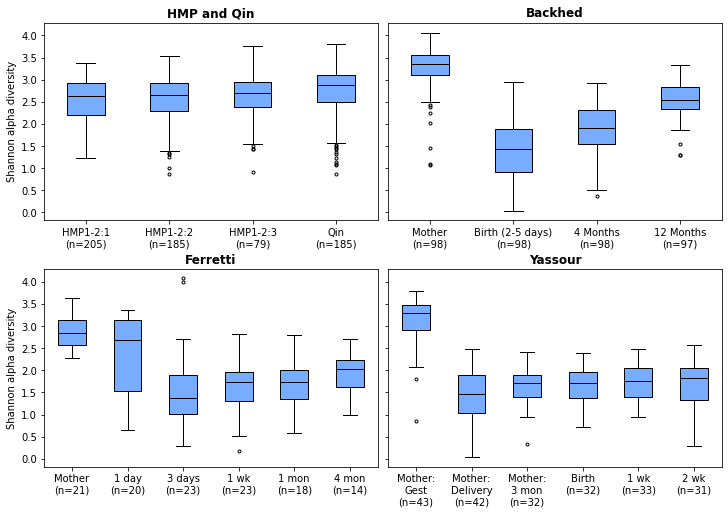

In [7]:
# Plot alpha diversity over time for each cohort

fig, ax = plt.subplots(2,2, figsize=(10,7), sharey=True, constrained_layout=True)

boxprops = dict(color='black')
medianprops = dict(color='black')
flierprops = dict(marker='.')

# HMP1-2
hmp_samples = su.get_sample_names('HMP')
order_alpha_div_dict = defaultdict(list)
order_subjects_dict = defaultdict(set)
for sample in hmp_samples:
    subject, order = sample_order_map[sample]
    if subject in order_subjects_dict[order]: # Ensure one sample per subject for particular timepoint bin
        continue
    order_subjects_dict[order].add(subject)
    alpha_div = alpha_div_dict[sample]
    order_alpha_div_dict[order].append(alpha_div)    

order_alpha_div_dict['Qin'] = list(qin_alpha_div_dict.values())

order_list = [1, 2, 3, 'Qin']
order_labels = ['HMP1-2:1', 'HMP1-2:2', 'HMP1-2:3', 'Qin']
order_labels_with_n = [label + '\n(n=%i)' % len(order_alpha_div_dict[o]) for label, o in zip(order_labels, order_list)]
plot_data = [order_alpha_div_dict[o] for o in order_list]

boxplots = ax[0][0].boxplot(plot_data, patch_artist=True, 
                 boxprops=boxprops, 
                 medianprops=medianprops,
                 flierprops=flierprops)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')
ax[0][0].set_xticklabels(order_labels_with_n)
ax[0][0].set_ylabel("Shannon alpha diversity")
ax[0][0].set_title("HMP and Qin", weight='bold')

# Backhed
backhed_samples = su.get_sample_names('Backhed')
order_alpha_div_dict = defaultdict(list)
order_subjects_dict = defaultdict(set)
for sample in backhed_samples:
    tp = su.sample_to_tp(sample, sample_order_map, hmp_samples, mother_samples_orig)
    subject, order = sample_order_map[sample]
    if subject in order_subjects_dict[tp]: # Ensure one sample per subject for particular timepoint bin
        continue
    order_subjects_dict[tp].add(subject)
    alpha_div = alpha_div_dict[sample]
    order_alpha_div_dict[tp].append(alpha_div)

order_list = ['M1', 'I1', 'I2', 'I3']
order_labels = ['Mother', 'Birth (2-5 days)', '4 Months', '12 Months']
order_labels_with_n = [label + '\n(n=%i)' % len(order_alpha_div_dict[o]) for label, o in zip(order_labels, order_list)]
plot_data = [order_alpha_div_dict[o] for o in order_list]

boxplots = ax[0][1].boxplot(plot_data, patch_artist=True, 
                 boxprops=boxprops, 
                 medianprops=medianprops,
                 flierprops=flierprops)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')
ax[0][1].set_xticklabels(order_labels_with_n)
ax[0][1].set_title("Backhed", weight='bold')

# Ferretti
ferretti_samples = su.get_sample_names('Ferretti')
order_alpha_div_dict = defaultdict(list)
order_subjects_dict = defaultdict(set)
for sample in ferretti_samples:
    tp = su.sample_to_tp(sample, sample_order_map, hmp_samples, mother_samples_orig)
    subject, order = sample_order_map[sample]
    if subject in order_subjects_dict[tp]: # Ensure one sample per subject for particular timepoint bin
        continue
    order_subjects_dict[tp].add(subject)
    alpha_div = alpha_div_dict[sample]
    order_alpha_div_dict[tp].append(alpha_div)

order_list = ['M1', 'I1', 'I2', 'I3', 'I4', 'I5']
order_labels = ['Mother', '1 day', '3 days', '1 wk', '1 mon', '4 mon']
order_labels_with_n = [label + '\n(n=%i)' % len(order_alpha_div_dict[o]) for label, o in zip(order_labels, order_list)]
plot_data = [order_alpha_div_dict[o] for o in order_list]

boxplots = ax[1][0].boxplot(plot_data, patch_artist=True, 
                 boxprops=boxprops, 
                 medianprops=medianprops,
                 flierprops=flierprops)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')
ax[1][0].set_xticklabels(order_labels_with_n)
ax[1][0].set_ylabel("Shannon alpha diversity")
ax[1][0].set_title("Ferretti", weight='bold')

# Yassour
yassour_samples = su.get_sample_names('Yassour')
order_alpha_div_dict = defaultdict(list)
order_subjects_dict = defaultdict(set)
for sample in yassour_samples:
    tp = su.sample_to_tp(sample, sample_order_map, hmp_samples, mother_samples_orig)
    subject, order = sample_order_map[sample]
    if subject in order_subjects_dict[tp]: # Ensure one sample per subject for particular timepoint bin
        continue
    order_subjects_dict[tp].add(subject)
    alpha_div = alpha_div_dict[sample]
    order_alpha_div_dict[tp].append(alpha_div)

order_list = ['M2', 'I1', 'I2', 'I3', 'I4', 'I5'] # Not including M1, M3
order_labels = ['Mother:\nGest', 'Mother:\nDelivery','Mother:\n3 mon', 'Birth', '1 wk', '2 wk', '1 mon', '2 mon', '3 mon']
order_labels_with_n = [label + '\n(n=%i)' % len(order_alpha_div_dict[o]) for label, o in zip(order_labels, order_list)]
plot_data = [order_alpha_div_dict[o] for o in order_list]

boxplots = ax[1][1].boxplot(plot_data, patch_artist=True, 
                 boxprops=boxprops, 
                 medianprops=medianprops,
                 flierprops=flierprops)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')
ax[1][1].set_xticklabels(order_labels_with_n)
ax[1][1].set_title("Yassour", weight='bold')

fig.savefig('%s/alpha_div_by_cohort_except_shao.pdf' % (config.analysis_directory), bbox_inches='tight')
plt.show()

In [8]:
# Compare timepoints

# Ferretti
ferretti_samples = su.get_sample_names('Ferretti')
order_alpha_div_dict = defaultdict(list)
for sample in ferretti_samples:
    tp = su.sample_to_tp(sample, sample_order_map, hmp_samples, mother_samples_orig)
    alpha_div = alpha_div_dict[sample]
    order_alpha_div_dict[tp].append(alpha_div)

order_list = ['M1', 'I1', 'I2', 'I3', 'I4', 'I5']
order_labels = ['Mother', '1 day', '3 days', '1 wk', '1 mon', '4 mon']

a = order_alpha_div_dict['I1']; b = order_alpha_div_dict['I2']
summarize_ttest(a, b)

# Backhed
backhed_samples = su.get_sample_names('Backhed')
order_alpha_div_dict = defaultdict(list)
for sample in backhed_samples:
    tp = su.sample_to_tp(sample, sample_order_map, hmp_samples, mother_samples_orig)
    alpha_div = alpha_div_dict[sample]
    order_alpha_div_dict[tp].append(alpha_div)

order_list = ['M1', 'I1', 'I2', 'I3']
order_labels = ['Mother', 'Birth (2-5 days)', '4 Months', '12 Months']

a = order_alpha_div_dict['I1']; b = order_alpha_div_dict['I3']
summarize_ttest(a, b)

Group 1 size: 20 | Group 2 size: 23
T-statistic: 2.4735
P-value: 0.017614547648533874
Cohen's D: 0.7562397462694491
Group 1 size: 98 | Group 2 size: 97
T-statistic: -14.0137
P-value: 3.0888566805758394e-31
Cohen's D: -2.0071145098000405


Group 1 size: 310 | Group 2 size: 85
T-statistic: -15.8555
P-value: 4.0420798115542096e-44
Cohen's D: -1.941281291994149


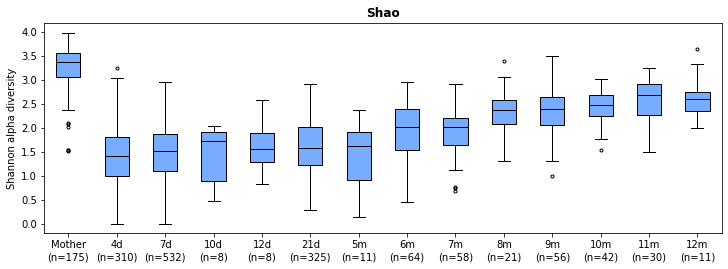

In [9]:
fig, ax = plt.subplots(figsize=(10, 3.6), sharey=True, constrained_layout=True)

boxprops = dict(color='black')
medianprops = dict(color='black')
flierprops = dict(marker='.')

# Shao
month_bins = np.arange(4, 15) * 30.5
order_bins = [0, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 21] + list(month_bins)

shao_samples = su.get_sample_names('Shao')
order_alpha_div_dict = defaultdict(list)
order_subjects_dict = defaultdict(set)

for sample in shao_samples:
    subject, order = sample_order_map[sample]
    if subject[-1] == 'M': # Mother
        tp = 0
    elif order > 21: # Convert to month bins
        tp = round_down(order, 30.5)
    else:
        tp = order
    
    if subject in order_subjects_dict[tp]: # Ensure one sample per subject for particular timepoint bin
        continue
    order_subjects_dict[tp].add(subject)
    alpha_div = alpha_div_dict[sample]
    order_alpha_div_dict[tp].append(alpha_div)

plot_data = [order_alpha_div_dict[o] for o in order_bins if len(order_alpha_div_dict[o]) > 5]
order_labels = ['Mother', '4d', '6d', '7d', '8d', '9d', '10d', '11d', '12d', '13d', '14d', '17d', '18d', '21d', '4m', '5m', '6m', '7m', '8m', '9m', '10m', '11m', '12m', '13m', '14m']
order_labels_with_n = [label + '\n(n=%i)' % len(order_alpha_div_dict[o]) for label, o in zip(order_labels, order_bins) if len(order_alpha_div_dict[o]) > 5]

boxplots = ax.boxplot(plot_data, patch_artist=True, 
                 boxprops=boxprops, 
                 medianprops=medianprops,
                 flierprops=flierprops)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

ax.set_xticklabels(order_labels_with_n)
ax.set_ylabel("Shannon alpha diversity")
ax.set_title("Shao", weight='bold')

summarize_ttest(order_alpha_div_dict[4], order_alpha_div_dict[335.5] + order_alpha_div_dict[366] + order_alpha_div_dict[305] + order_alpha_div_dict[396.5])

fig.savefig('%s/alpha_div_by_cohort_shao.pdf' % (config.analysis_directory), bbox_inches='tight')

In [10]:
# Store alpha diversity CSV for GLMM analysis

f = open('%s/alpha_div.csv' % config.analysis_directory, 'w')
f.write(','.join(['sample', 'subject', 'day', 'cohort', 'alpha_div', 'breast', 'formula', 'vaginal', 'csection']) + '\n')

for sample in infant_samples:
    cohort = sample_cohort_map[sample]
    subject = sample_subject_map[sample]
    day = mi_sample_day_dict[sample]
    alpha_div = alpha_div_dict[sample]
    
    feeding_mode = subject_feeding_mode_map[subject] if subject in subject_feeding_mode_map else 'NA'
    if feeding_mode == 'breast':
        breast = 1; formula = 0
    elif feeding_mode == 'mixed':
        breast = 1; formula = 1
    elif feeding_mode == 'formula':
        breast = 0; formula = 1
    else:
        breast = 'NA'; formula = 'NA'
    
    delivery_mode = subject_delivery_mode_map[subject] if subject in subject_delivery_mode_map else 'NA'
    if delivery_mode == 'Vaginal':
        vaginal = 1; csection = 0
    elif delivery_mode == 'C-section':
        vaginal = 0; csection = 1
    else:
        vaginal = 'NA'; csection = 'NA'
    
    f.write(','.join([str(val) for val in [sample, subject, day, cohort, alpha_div, breast, formula, vaginal, csection]]) + '\n')

f.close()

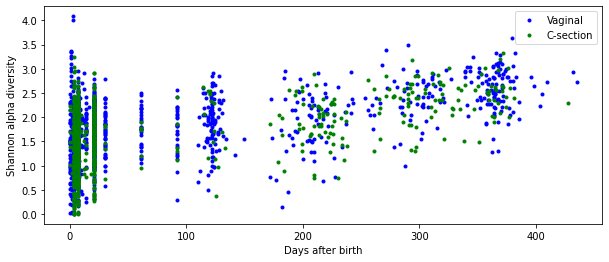

In [11]:
# Compare C section and vaginal delivery
subject_delivery_mode_map = su.parse_subject_delivery_mode_map()

vaginal_days = []
vaginal_alpha_divs = []
csection_days = []
csection_alpha_divs = []

for sample in infant_samples:
    day = mi_sample_day_dict[sample]
    subject = sample_subject_map[sample]
    delivery_mode = subject_delivery_mode_map[subject]
    alpha_div = alpha_div_dict[sample]
    
    if delivery_mode == 'Vaginal':
        vaginal_days.append(day); vaginal_alpha_divs.append(alpha_div)
    elif delivery_mode == 'C-section':
        csection_days.append(day); csection_alpha_divs.append(alpha_div)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(vaginal_days, vaginal_alpha_divs, 'b.', label='Vaginal')
ax.plot(csection_days, csection_alpha_divs, 'g.', label='C-section')
# ax.set_xscale('log')
ax.set_ylabel("Shannon alpha diversity")
ax.set_xlabel('Days after birth')
ax.legend()
plt.show()

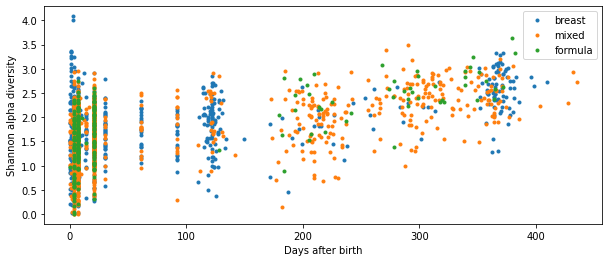

In [9]:
# Compare feeding modes
subject_feeding_mode_map = su.parse_subject_feeding_mode_map()

days_by_category = defaultdict(list)
alpha_divs_by_category = defaultdict(list)

cats = ['breast', 'mixed', 'formula']

for sample in infant_samples:
    day = mi_sample_day_dict[sample]
    subject = sample_subject_map[sample]
    
    if subject in subject_feeding_mode_map:
        feeding_mode = subject_feeding_mode_map[subject]
        alpha_div = alpha_div_dict[sample]
        days_by_category[feeding_mode].append(day)
        alpha_divs_by_category[feeding_mode].append(alpha_div)

fig, ax = plt.subplots(figsize=(10, 4))

for cat in cats:
    ax.plot(days_by_category[cat], alpha_divs_by_category[cat], '.', label=cat)

# ax.set_xscale('log')
ax.set_ylabel("Shannon alpha diversity")
ax.set_xlabel('Days after birth')
ax.legend()
plt.show()

[Text(1, 0, 'birth\nn=36'),
 Text(2, 0, 'birth\nn=6'),
 Text(3, 0, '1d\nn=20'),
 Text(4, 0, '1d\nn=0'),
 Text(5, 0, '3d\nn=106'),
 Text(6, 0, '3d\nn=15'),
 Text(7, 0, '4d\nn=157'),
 Text(8, 0, '4d\nn=153'),
 Text(9, 0, '1w\nn=319'),
 Text(10, 0, '1w\nn=262'),
 Text(11, 0, '2w\nn=31'),
 Text(12, 0, '2w\nn=8'),
 Text(13, 0, '3w\nn=147'),
 Text(14, 0, '3w\nn=178'),
 Text(15, 0, '1m\nn=45'),
 Text(16, 0, '1m\nn=5'),
 Text(17, 0, '2m\nn=28'),
 Text(18, 0, '2m\nn=5'),
 Text(19, 0, '3m\nn=26'),
 Text(20, 0, '3m\nn=5'),
 Text(21, 0, '4m\nn=98'),
 Text(22, 0, '4m\nn=15'),
 Text(23, 0, '5m\nn=6'),
 Text(24, 0, '5m\nn=5'),
 Text(25, 0, '6m\nn=38'),
 Text(26, 0, '6m\nn=21'),
 Text(27, 0, '7m\nn=29'),
 Text(28, 0, '7m\nn=34'),
 Text(29, 0, '8m\nn=11'),
 Text(30, 0, '8m\nn=9'),
 Text(31, 0, '9m\nn=30'),
 Text(32, 0, '9m\nn=27'),
 Text(33, 0, '10m\nn=19'),
 Text(34, 0, '10m\nn=22'),
 Text(35, 0, '11m\nn=19'),
 Text(36, 0, '11m\nn=12'),
 Text(37, 0, '1y\nn=89'),
 Text(38, 0, '1y\nn=24')]

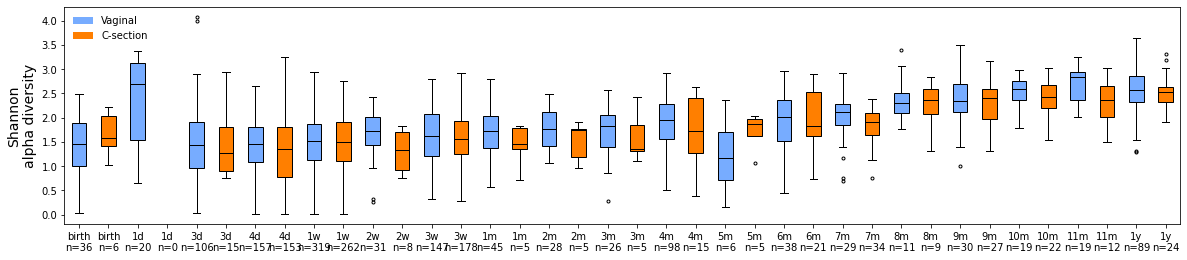

In [16]:
fig, ax = plt.subplots(figsize=(20,4))

infant_tps = [tp for tp in tps_ordered_dict['infant']]
infant_tps.remove('6 day')
all_tps = infant_tps

# Alpha diversity ========================================
alpha_divs = [] # list of sample values for each tp
labels = []

for tp in infant_tps:
    num_samples = len(mi_tp_sample_dict['infant'][tp])
    
    vaginal_samples = []; csection_samples = []
    for sample in mi_tp_sample_dict['infant'][tp]:
        delivery_mode = subject_delivery_mode_map[sample_subject_map[sample]]
        if delivery_mode == 'Vaginal':
            vaginal_samples.append(sample)
        elif delivery_mode == 'C-section':
            csection_samples.append(sample)
    
    if tp != 'birth':
        num, unit = tp.split(' ')
        tp = num+unit[0]
    alpha_divs.append([alpha_div_dict[sample] for sample in vaginal_samples])
    labels.append(tp + "\n" + ("n=%i" % len(vaginal_samples)))
    alpha_divs.append([alpha_div_dict[sample] for sample in csection_samples])
    labels.append(tp + "\n" + ("n=%i" % len(csection_samples)))

boxprops = dict(color='#77acff')
medianprops = dict(color='black')
flierprops = dict(marker='.')

boxplots = ax.boxplot(alpha_divs, patch_artist=True, 
                         medianprops=medianprops,
                         flierprops=flierprops)

for i in np.arange(len(alpha_divs), step=2):
    boxplots['boxes'][i].set_facecolor(plot_utils.col_blue) # Vaginal
    boxplots['boxes'][i+1].set_facecolor(plot_utils.col_orange) # C-section

legend_elements = [Patch(facecolor=plot_utils.col_blue, label='Vaginal'), Patch(facecolor=plot_utils.col_orange, label='C-section')]
ax.legend(handles=legend_elements, loc='upper left', frameon=False)

ax.set_ylabel("Shannon\nalpha diversity", fontsize=14)
ax.set_xticklabels(labels)

[Text(1, 0, 'birth\nn=20'),
 Text(2, 0, 'birth\nn=12'),
 Text(3, 0, 'birth\nn=0'),
 Text(4, 0, '1d\nn=20'),
 Text(5, 0, '1d\nn=0'),
 Text(6, 0, '1d\nn=0'),
 Text(7, 0, '3d\nn=95'),
 Text(8, 0, '3d\nn=25'),
 Text(9, 0, '3d\nn=1'),
 Text(10, 0, '4d\nn=82'),
 Text(11, 0, '4d\nn=162'),
 Text(12, 0, '4d\nn=56'),
 Text(13, 0, '1w\nn=154'),
 Text(14, 0, '1w\nn=305'),
 Text(15, 0, '1w\nn=85'),
 Text(16, 0, '2w\nn=20'),
 Text(17, 0, '2w\nn=13'),
 Text(18, 0, '2w\nn=1'),
 Text(19, 0, '3w\nn=70'),
 Text(20, 0, '3w\nn=191'),
 Text(21, 0, '3w\nn=56'),
 Text(22, 0, '1m\nn=38'),
 Text(23, 0, '1m\nn=12'),
 Text(24, 0, '1m\nn=0'),
 Text(25, 0, '2m\nn=20'),
 Text(26, 0, '2m\nn=13'),
 Text(27, 0, '2m\nn=0'),
 Text(28, 0, '3m\nn=18'),
 Text(29, 0, '3m\nn=13'),
 Text(30, 0, '3m\nn=0'),
 Text(31, 0, '4m\nn=86'),
 Text(32, 0, '4m\nn=26'),
 Text(33, 0, '4m\nn=1'),
 Text(34, 0, '5m\nn=3'),
 Text(35, 0, '5m\nn=6'),
 Text(36, 0, '5m\nn=2'),
 Text(37, 0, '6m\nn=6'),
 Text(38, 0, '6m\nn=43'),
 Text(39, 0, '6m\nn=1

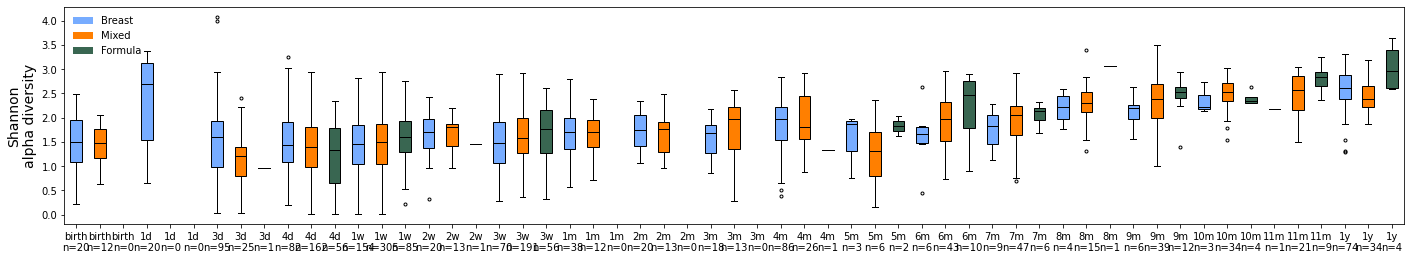

In [21]:
fig, ax = plt.subplots(figsize=(24,4))

infant_tps = [tp for tp in tps_ordered_dict['infant']]
infant_tps.remove('6 day')
all_tps = infant_tps

cats = ['breast', 'mixed', 'formula']

# Alpha diversity ========================================
alpha_divs = [] # list of sample values for each tp
labels = []

for tp in infant_tps:
    num_samples = len(mi_tp_sample_dict['infant'][tp])
    
    samples_by_category = defaultdict(list)
    for sample in mi_tp_sample_dict['infant'][tp]:
        subject = sample_subject_map[sample]
        if subject in subject_feeding_mode_map:
            feeding_mode = subject_feeding_mode_map[subject]
            samples_by_category[feeding_mode].append(sample)
    
    if tp != 'birth':
        num, unit = tp.split(' ')
        tp = num+unit[0]
    
    for cat in cats:
        alpha_divs.append([alpha_div_dict[sample] for sample in samples_by_category[cat]])
        labels.append(tp + "\n" + ("n=%i" % len(samples_by_category[cat])))

boxprops = dict(color='#77acff'); medianprops = dict(color='black'); flierprops = dict(marker='.')
boxplots = ax.boxplot(alpha_divs, patch_artist=True, medianprops=medianprops, flierprops=flierprops)

for i in np.arange(len(alpha_divs), step=3):
    boxplots['boxes'][i].set_facecolor(plot_utils.col_blue) # Breast
    boxplots['boxes'][i+1].set_facecolor(plot_utils.col_orange) # Mixed
    boxplots['boxes'][i+2].set_facecolor(plot_utils.col_darkgreen) # Formula

legend_elements = [Patch(facecolor=plot_utils.col_blue, label='Breast'), 
                   Patch(facecolor=plot_utils.col_orange, label='Mixed'),
                   Patch(facecolor=plot_utils.col_darkgreen, label='Formula')]
ax.legend(handles=legend_elements, loc='upper left', frameon=False)

ax.set_ylabel("Shannon\nalpha diversity", fontsize=14)
ax.set_xticklabels(labels)

In [23]:
# quick overview of feeding mode info

cohort_cat_dict = {cohort: defaultdict(int) for cohort in ['backhed', 'ferretti', 'yassour', 'shao']}

for sample in infant_samples:
    cohort = sample_cohort_map[sample]
    subject = sample_subject_map[sample]
    if subject in subject_feeding_mode_map:
        cat = subject_feeding_mode_map[subject]
        cohort_cat_dict[cohort][cat] += 1

cohort_cat_dict

{'backhed': defaultdict(int, {'breast': 215, 'mixed': 75, 'formula': 3}),
 'ferretti': defaultdict(int, {'breast': 98}),
 'yassour': defaultdict(int, {'breast': 98, 'mixed': 62}),
 'shao': defaultdict(int, {'formula': 245, 'breast': 318, 'mixed': 874})}

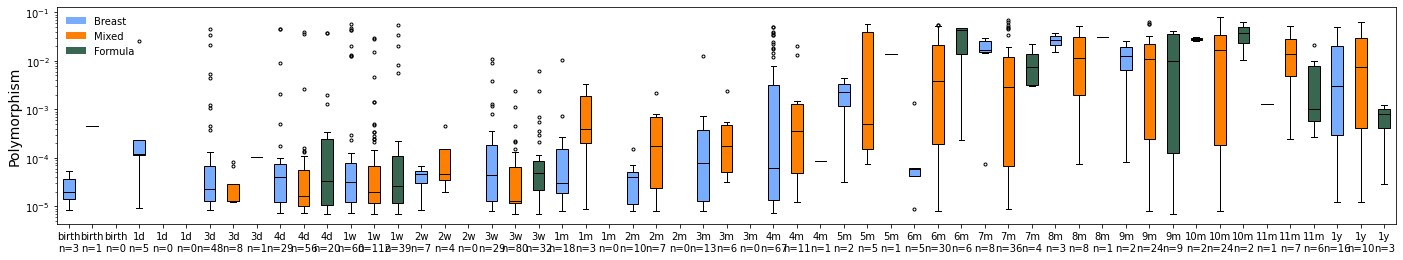

In [25]:
fig, ax = plt.subplots(figsize=(24,4))

infant_tps = [tp for tp in tps_ordered_dict['infant']]
infant_tps.remove('6 day')
all_tps = infant_tps

cats = ['breast', 'mixed', 'formula']

# Polymorphism for E. coli ===============================
desired_species = 'Escherichia_coli_58110'
polymorphisms = [] # list of sample values for each tp
labels = []

for tp in infant_tps:
    num_samples = len(mi_tp_sample_dict['infant'][tp])
    
    samples_by_category = defaultdict(list)
    for sample in mi_tp_sample_dict['infant'][tp]:
        subject = sample_subject_map[sample]
        if desired_species in sample_species_polymorphism_dict[sample] and subject in subject_feeding_mode_map:
            feeding_mode = subject_feeding_mode_map[subject]
            samples_by_category[feeding_mode].append(sample)
    
    if tp != 'birth':
        num, unit = tp.split(' ')
        tp = num+unit[0]
    
    for cat in cats:
        polymorphisms.append([sample_species_polymorphism_dict[sample][desired_species] for sample in samples_by_category[cat]])
        labels.append(tp + "\n" + ("n=%i" % len(samples_by_category[cat])))

boxprops = dict(color='#77acff'); medianprops = dict(color='black'); flierprops = dict(marker='.')
boxplots = ax.boxplot(polymorphisms, patch_artist=True, medianprops=medianprops, flierprops=flierprops)

for i in np.arange(len(alpha_divs), step=3):
    boxplots['boxes'][i].set_facecolor(plot_utils.col_blue) # Breast
    boxplots['boxes'][i+1].set_facecolor(plot_utils.col_orange) # Mixed
    boxplots['boxes'][i+2].set_facecolor(plot_utils.col_darkgreen) # Formula

legend_elements = [Patch(facecolor=plot_utils.col_blue, label='Breast'), 
                   Patch(facecolor=plot_utils.col_orange, label='Mixed'),
                   Patch(facecolor=plot_utils.col_darkgreen, label='Formula')]
ax.legend(handles=legend_elements, loc='upper left', frameon=False)

ax.set_ylabel("Polymorphism", fontsize=14)
ax.set_xticklabels(labels)
ax.set_yscale('log')

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))

infant_tps = [tp for tp in tps_ordered_dict['infant']]
infant_tps.remove('6 day')
all_tps = infant_tps

# Polymorphism for E. coli ===============================
desired_species = 'Escherichia_coli_58110'
polymorphisms = [] # list of sample values for each tp
labels = []

for tp in infant_tps:
    num_samples = len(mi_tp_sample_dict['infant'][tp])
    
    vaginal_samples = []; csection_samples = []
    for sample in mi_tp_sample_dict['infant'][tp]:
        if desired_species in sample_species_polymorphism_dict[sample]:
            delivery_mode = subject_delivery_mode_map[sample_subject_map[sample]]
            if delivery_mode == 'Vaginal':
                vaginal_samples.append(sample)
            elif delivery_mode == 'C-section':
                csection_samples.append(sample)
    
    if tp != 'birth':
        num, unit = tp.split(' ')
        tp = num+unit[0]
    polymorphisms.append([sample_species_polymorphism_dict[sample][desired_species] for sample in vaginal_samples])
    labels.append(tp + "\n" + ("n=%i" % len(vaginal_samples)))
    polymorphisms.append([sample_species_polymorphism_dict[sample][desired_species] for sample in csection_samples])
    labels.append(tp + "\n" + ("n=%i" % len(csection_samples)))

boxprops = dict(color='#77acff')
medianprops = dict(color='black')
flierprops = dict(marker='.')

boxplots = ax.boxplot(polymorphisms, patch_artist=True, 
                         medianprops=medianprops,
                         flierprops=flierprops)

for i in np.arange(len(alpha_divs), step=2):
    boxplots['boxes'][i].set_facecolor(plot_utils.col_blue) # Vaginal
    boxplots['boxes'][i+1].set_facecolor(plot_utils.col_orange) # C-section

legend_elements = [Patch(facecolor=plot_utils.col_blue, label='Vaginal'), Patch(facecolor=plot_utils.col_orange, label='C-section')]
ax.legend(handles=legend_elements, loc='upper left', frameon=False)

ax.set_ylabel("Polymorphism", fontsize=14)
ax.set_xticklabels(labels)
ax.set_yscale('log')

## Wait, of course there aren't multiple same-subject timepoints here (only grouping together the infancy timepoints by month for Shao), but there could be for grouping by week in Shao later.

Cohen's D: -0.06701722896436017
p: 0.8072817685273871
Cohen's D: 0.28504659422523715
p: 0.11789852471459246
Cohen's D: 0.2120668264552229
p: 0.31981195599106715
Cohen's D: 0.7473411415278708
p: 0.12915831278102363
Cohen's D: -0.1382893023337246
p: 0.6390569134289956
Cohen's D: 0.2612131720702507
p: 0.1536732231465008
Cohen's D: 0.13857013782471805
p: 0.567516558257074
Cohen's D: 0.14585978778283312
p: 0.610717695527101
Cohen's D: -0.047164750976257594
p: 0.7490494455117632


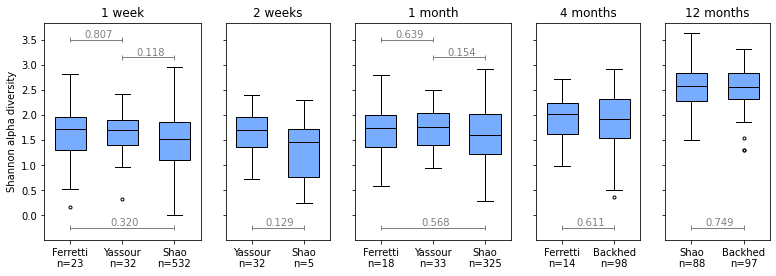

In [9]:
# Compare datasets

cohorts = ['hmp', 'backhed', 'ferretti', 'yassour', 'shao']
cohort_tp_alpha_div_dict = {cohort: defaultdict(list) for cohort in cohorts}

for sample in sample_cohort_map:
    tp = su.sample_to_tp(sample, sample_order_map, hmp_samples, mother_samples_orig)
    cohort = sample_cohort_map[sample]
    if cohort == 'shao':
        subject, order = sample_order_map[sample]
        if subject[-1] == 'M': # Mother
            tp = 0
        elif order > 21: # Convert to month bins
            tp = round_down(order, 30.5)
        else:
            tp = order
    if cohort not in cohorts:
        continue
    cohort_tp_alpha_div_dict[cohort][tp].append(alpha_div_dict[sample])

fig, ax = plt.subplots(1, 5, figsize=(13, 4), 
                       sharey=True,
                       gridspec_kw={'width_ratios': [3, 2, 3, 2, 2]})

# 1 week
cohort_tp_tups = [('ferretti', 'I3'), ('yassour', 'I2'), ('shao',7)]
plot_data = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]

boxplots = ax[0].boxplot(plot_data, patch_artist=True, 
                 boxprops=dict(color='black'), 
                 medianprops=dict(color='black'),
                 flierprops=dict(marker='.'), widths=0.6)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j in zip([(0, 1), (1, 2), (0, 2)], [3.5, 3.15, -0.25]):
    i1, i2 = itup
    t, p = scipy.stats.ttest_ind(plot_data[i1], plot_data[i2])
    print("Cohen's D: %s" % str(cohenD(plot_data[i1], plot_data[i2])))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[0], j, i1+1, i2+1, color=color, tickh=0.05)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[0].text(i1+1+((i2-i1)/2)-offset, j+0.04, label, color=color)

ax[0].set_title('1 week')
ax[0].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(cohort_tp_alpha_div_dict[cohort][tp])) \
                       for (cohort, tp) in cohort_tp_tups])
ax[0].set_ylabel('Shannon alpha diversity')

# 2 weeks
cohort_tp_tups = [('yassour', 'I3'), ('shao',14)]
plot_data = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]

boxplots = ax[1].boxplot(plot_data, patch_artist=True, 
                 boxprops=dict(color='black'), 
                 medianprops=dict(color='black'),
                 flierprops=dict(marker='.'), widths=0.6)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j in zip([(0, 1)], [-0.25]):
    i1, i2 = itup
    t, p = scipy.stats.ttest_ind(plot_data[i1], plot_data[i2])
    print("Cohen's D: %s" % str(cohenD(plot_data[i1], plot_data[i2])))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[1], j, i1+1, i2+1, color=color, tickh=0.05)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[1].text(i1+1+((i2-i1)/2)-offset, j+0.04, label, color=color)

ax[1].set_title('2 weeks')
ax[1].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(cohort_tp_alpha_div_dict[cohort][tp])) \
                       for (cohort, tp) in cohort_tp_tups])

# 1 month
cohort_tp_tups = [('ferretti', 'I4'), ('yassour', 'I4'), ('shao',21)]
plot_data = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]

boxplots = ax[2].boxplot(plot_data, patch_artist=True, widths=0.6, boxprops=dict(color='black'), medianprops=dict(color='black'), flierprops=dict(marker='.'))
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j in zip([(0, 1), (1, 2), (0, 2)], [3.5, 3.15, -0.25]):
    i1, i2 = itup
    t, p = scipy.stats.ttest_ind(plot_data[i1], plot_data[i2])
    print("Cohen's D: %s" % str(cohenD(plot_data[i1], plot_data[i2])))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[2], j, i1+1, i2+1, color=color, tickh=0.05)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[2].text(i1+1+((i2-i1)/2)-offset, j+0.04, label, color=color)

ax[2].set_title('1 month')
ax[2].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(cohort_tp_alpha_div_dict[cohort][tp])) \
                       for (cohort, tp) in cohort_tp_tups])

# 4 months
cohort_tp_tups = [('ferretti', 'I5'), ('backhed', 'I2')]
plot_data = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]

boxplots = ax[3].boxplot(plot_data, patch_artist=True, 
                 boxprops=dict(color='black'), 
                 medianprops=dict(color='black'),
                 flierprops=dict(marker='.'), widths=0.6)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j in zip([(0, 1)], [-0.25]):
    i1, i2 = itup
    t, p = scipy.stats.ttest_ind(plot_data[i1], plot_data[i2])
    print("Cohen's D: %s" % str(cohenD(plot_data[i1], plot_data[i2])))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[3], j, i1+1, i2+1, color=color, tickh=0.05)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[3].text(i1+1+((i2-i1)/2)-offset, j+0.04, label, color=color)

ax[3].set_title('4 months')
ax[3].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(cohort_tp_alpha_div_dict[cohort][tp])) \
                       for (cohort, tp) in cohort_tp_tups])

# 12 months
a = []
for tp in cohort_tp_alpha_div_dict['shao']:
    if tp > 300:
        a += cohort_tp_alpha_div_dict['shao'][tp]
b = cohort_tp_alpha_div_dict['backhed']['I3']
plot_data = [a, b]

boxplots = ax[4].boxplot(plot_data, patch_artist=True, 
                 boxprops=dict(color='black'), 
                 medianprops=dict(color='black'),
                 flierprops=dict(marker='.'), widths=0.6)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j in zip([(0, 1)], [-0.25]):
    i1, i2 = itup
    t, p = scipy.stats.ttest_ind(plot_data[i1], plot_data[i2])
    print("Cohen's D: %s" % str(cohenD(plot_data[i1], plot_data[i2])))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[4], j, i1+1, i2+1, color=color, tickh=0.05)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[4].text(i1+1+((i2-i1)/2)-offset, j+0.04, label, color=color)

ax[4].set_title('12 months')
ax[4].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(vals)) \
                       for (cohort, vals) in zip(['shao', 'backhed'], [a, b])])

fig.savefig('%s/alpha_div_compare_cohort_matched_tp.pdf' % (config.analysis_directory), bbox_inches='tight')

In [10]:
# Store data for R Q-Q plots

# 1 week
cohort_tp_tups = [('ferretti', 'I3'), ('yassour', 'I2'), ('shao',7)]
for (cohort, tp) in cohort_tp_tups:
    alpha_divs = cohort_tp_alpha_div_dict[cohort][tp]
    with open('%s/alpha_divs_%s_%s.txt' % (config.analysis_directory, cohort, '1wk'), 'w') as f:
        f.write('\n'.join([str(ad) for ad in alpha_divs]))

# 2 weeks
cohort_tp_tups = [('yassour', 'I3'), ('shao',14)]
for (cohort, tp) in cohort_tp_tups:
    alpha_divs = cohort_tp_alpha_div_dict[cohort][tp]
    with open('%s/alpha_divs_%s_%s.txt' % (config.analysis_directory, cohort, '2wk'), 'w') as f:
        f.write('\n'.join([str(ad) for ad in alpha_divs]))

# 1 month
cohort_tp_tups = [('ferretti', 'I4'), ('yassour', 'I4'), ('shao',21)]
for (cohort, tp) in cohort_tp_tups:
    alpha_divs = cohort_tp_alpha_div_dict[cohort][tp]
    with open('%s/alpha_divs_%s_%s.txt' % (config.analysis_directory, cohort, '1mo'), 'w') as f:
        f.write('\n'.join([str(ad) for ad in alpha_divs]))

# 4 months
cohort_tp_tups = [('ferretti', 'I5'), ('backhed', 'I2')]
for (cohort, tp) in cohort_tp_tups:
    alpha_divs = cohort_tp_alpha_div_dict[cohort][tp]
    with open('%s/alpha_divs_%s_%s.txt' % (config.analysis_directory, cohort, '4mo'), 'w') as f:
        f.write('\n'.join([str(ad) for ad in alpha_divs]))

# 12 months
a = []
for tp in cohort_tp_alpha_div_dict['shao']:
    if tp > 300:
        a += cohort_tp_alpha_div_dict['shao'][tp]
b = cohort_tp_alpha_div_dict['backhed']['I3']
for cohort, alpha_divs in zip(['shao', 'backhed'], [a, b]):
    with open('%s/alpha_divs_%s_%s.txt' % (config.analysis_directory, cohort, '1yr'), 'w') as f:
        f.write('\n'.join([str(ad) for ad in alpha_divs]))

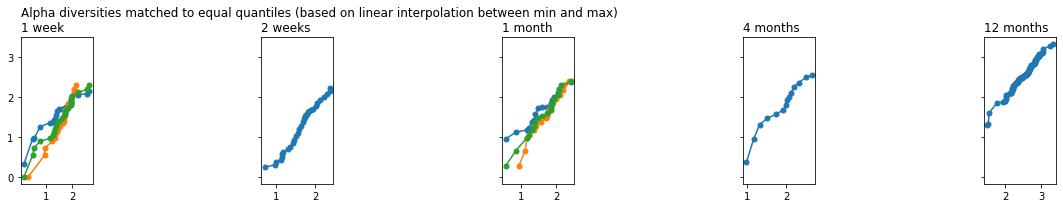

In [11]:
# Fake Q-Q plots to check validity of T test

fig, ax = plt.subplots(1, 5, figsize=(15, 3), 
                       sharey=True)

# 1 week
cohort_tp_tups = [('ferretti', 'I3'), ('yassour', 'I2'), ('shao',7)]
x = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
y = [[np.quantile(x[j], i) for i in np.arange(0, 1, step=(1/len(x[0])))] for j in [0, 1, 2]]
ax[0].plot(y[0], y[1], '.-', markersize=10)
ax[0].plot(y[1], y[2], '.-', markersize=10)
ax[0].plot(y[0], y[2], '.-', markersize=10)
ax[0].set_title("Alpha diversities matched to equal quantiles (based on linear interpolation between min and max)\n1 week", loc='left')

# 2 weeks
cohort_tp_tups = [('yassour', 'I3'), ('shao',14)]
x = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
y = [[np.quantile(x[j], i) for i in np.arange(0, 1, step=(1/len(x[0])))] for j in [0, 1]]
ax[1].plot(y[0], y[1], '.-', markersize=10)
ax[1].set_title("2 weeks", loc='left')

# 1 month
cohort_tp_tups = [('ferretti', 'I4'), ('yassour', 'I4'), ('shao',21)]
x = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
y = [[np.quantile(x[j], i) for i in np.arange(0, 1, step=(1/len(x[0])))] for j in [0, 1, 2]]
ax[2].plot(y[0], y[1], '.-', markersize=10)
ax[2].plot(y[1], y[2], '.-', markersize=10)
ax[2].plot(y[0], y[2], '.-', markersize=10)
ax[2].set_title("1 month", loc='left')

# 4 months
cohort_tp_tups = [('ferretti', 'I5'), ('backhed', 'I2')]
x = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
y = [[np.quantile(x[j], i) for i in np.arange(0, 1, step=(1/len(x[0])))] for j in [0, 1]]
ax[3].plot(y[0], y[1], '.-', markersize=10)
ax[3].set_title("4 months", loc='left')

# 12 months
a = []
for tp in cohort_tp_alpha_div_dict['shao']:
    if tp > 300:
        a += cohort_tp_alpha_div_dict['shao'][tp]
b = cohort_tp_alpha_div_dict['backhed']['I3']
x = [a, b]
y = [[np.quantile(x[j], i) for i in np.arange(0, 1, step=(1/len(x[0])))] for j in [0, 1]]
ax[4].plot(y[0], y[1], '.-', markersize=10)
ax[4].set_title("12 months", loc='left')

plt.tight_layout()

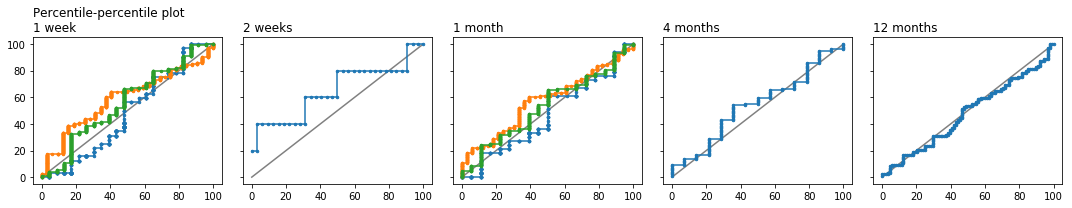

In [13]:
# Actual Q-Q plots to check validity of T test

fig, ax = plt.subplots(1, 5, figsize=(15, 3), 
                       sharey=True)

# 1 week
cohort_tp_tups = [('ferretti', 'I3'), ('yassour', 'I2'), ('shao',7)]
x = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
all_vals = sorted(list(set(x[0]+x[1]+x[2])))
y = [[stats.percentileofscore(x[j], val) for val in all_vals] for j in [0, 1, 2]]
ax[0].plot(np.arange(100), np.arange(100), '-', color='gray')
ax[0].plot(y[0], y[1], '.-', markersize=5)
ax[0].plot(y[1], y[2], '.-', markersize=5)
ax[0].plot(y[0], y[2], '.-', markersize=5)
ax[0].set_title("Percentile-percentile plot\n1 week", loc='left')

# 2 weeks
cohort_tp_tups = [('yassour', 'I3'), ('shao',14)]
x = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
all_vals = sorted(list(set(x[0]+x[1])))
y = [[stats.percentileofscore(x[j], val) for val in all_vals] for j in [0, 1]]
ax[1].plot(np.arange(100), np.arange(100), '-', color='gray')
ax[1].plot(y[0], y[1], '.-', markersize=5)
ax[1].set_title("2 weeks", loc='left')

# 1 month
cohort_tp_tups = [('ferretti', 'I4'), ('yassour', 'I4'), ('shao',21)]
x = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
all_vals = sorted(list(set(x[0]+x[1]+x[2])))
y = [[stats.percentileofscore(x[j], val) for val in all_vals] for j in [0, 1, 2]]
ax[2].plot(np.arange(100), np.arange(100), '-', color='gray')
ax[2].plot(y[0], y[1], '.-', markersize=5)
ax[2].plot(y[1], y[2], '.-', markersize=5)
ax[2].plot(y[0], y[2], '.-', markersize=5)
ax[2].set_title("1 month", loc='left')

# 4 months
cohort_tp_tups = [('ferretti', 'I5'), ('backhed', 'I2')]
x = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
all_vals = sorted(list(set(x[0]+x[1])))
y = [[stats.percentileofscore(x[j], val) for val in all_vals] for j in [0, 1]]
ax[3].plot(np.arange(100), np.arange(100), '-', color='gray')
ax[3].plot(y[0], y[1], '.-', markersize=5)
ax[3].set_title("4 months", loc='left')

# 12 months
a = []
for tp in cohort_tp_alpha_div_dict['shao']:
    if tp > 300:
        a += cohort_tp_alpha_div_dict['shao'][tp]
b = cohort_tp_alpha_div_dict['backhed']['I3']
x = [a, b]
all_vals = sorted(list(set(x[0]+x[1])))
y = [[stats.percentileofscore(x[j], val) for val in all_vals] for j in [0, 1]]
ax[4].plot(np.arange(100), np.arange(100), '-', color='gray')
ax[4].plot(y[0], y[1], '.-', markersize=5)
ax[4].set_title("12 months", loc='left')

plt.tight_layout()

Text(0.5, 1.0, 'Backhed - 12mo')

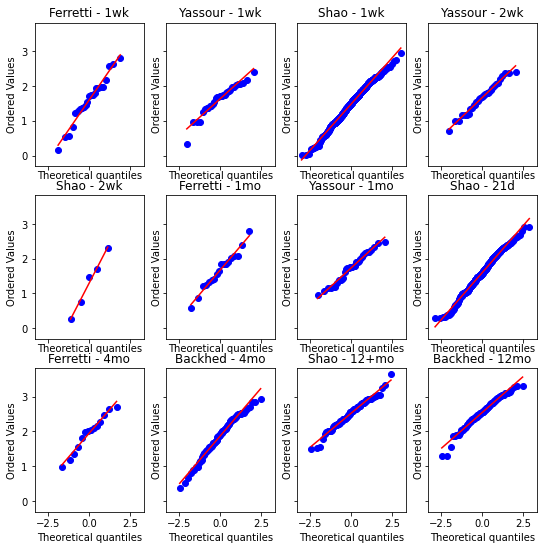

In [43]:
from scipy import stats

fig, ax = plt.subplots(3, 4, figsize=(9, 9),sharey=True, sharex=True)

# 1 week
cohort_tp_tups = [('ferretti', 'I3'), ('yassour', 'I2'), ('shao',7)]
x = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
stats.probplot(x[0], plot=ax[0][0]); ax[0][0].set_title("Ferretti - 1wk")
stats.probplot(x[1], plot=ax[0][1]); ax[0][1].set_title("Yassour - 1wk")
stats.probplot(x[2], plot=ax[0][2]); ax[0][2].set_title("Shao - 1wk")

# 2 weeks
cohort_tp_tups = [('yassour', 'I3'), ('shao',14)]
x = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
stats.probplot(x[0], plot=ax[0][3]); ax[0][3].set_title("Yassour - 2wk")
stats.probplot(x[1], plot=ax[1][0]); ax[1][0].set_title("Shao - 2wk")

# 1 month
cohort_tp_tups = [('ferretti', 'I4'), ('yassour', 'I4'), ('shao',21)]
x = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
stats.probplot(x[0], plot=ax[1][1]); ax[1][1].set_title("Ferretti - 1mo")
stats.probplot(x[1], plot=ax[1][2]); ax[1][2].set_title("Yassour - 1mo")
stats.probplot(x[2], plot=ax[1][3]); ax[1][3].set_title("Shao - 21d")

# 4 months
cohort_tp_tups = [('ferretti', 'I5'), ('backhed', 'I2')]
x = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
stats.probplot(x[0], plot=ax[2][0]); ax[2][0].set_title("Ferretti - 4mo")
stats.probplot(x[1], plot=ax[2][1]); ax[2][1].set_title("Backhed - 4mo")

# 12 months
a = []
for tp in cohort_tp_alpha_div_dict['shao']:
    if tp > 300:
        a += cohort_tp_alpha_div_dict['shao'][tp]
b = cohort_tp_alpha_div_dict['backhed']['I3']
x = [a, b]
stats.probplot(x[0], plot=ax[2][2]); ax[2][2].set_title("Shao - 12+mo")
stats.probplot(x[1], plot=ax[2][3]); ax[2][3].set_title("Backhed - 12mo")

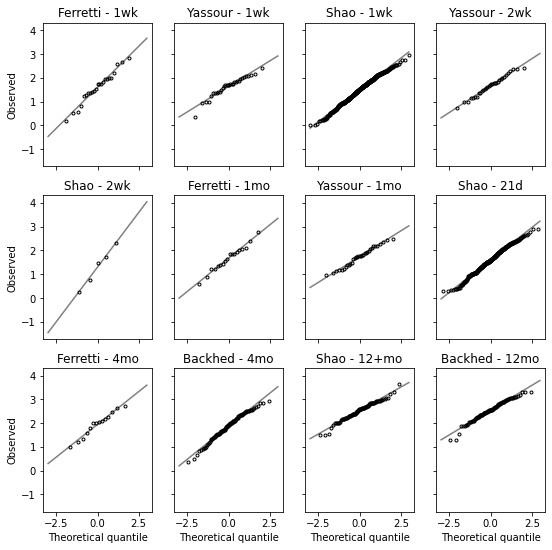

In [11]:
from scipy import stats

fig, ax = plt.subplots(3, 4, figsize=(9, 9),sharey=True, sharex=True)
xs = np.arange(-3, 3, 0.01)

# 1 week
cohort_tp_tups = [('ferretti', 'I3'), ('yassour', 'I2'), ('shao',7)]
x = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
vals = stats.probplot(x[0]); ax[0][0].set_title("Ferretti - 1wk")
osm, osr = vals[0]; m, b, r = vals[1]; ax[0][0].plot(xs, (m*xs)+b, color='gray'); ax[0][0].plot(osm, osr, '.', color='black', mfc='none')
vals = stats.probplot(x[1]); ax[0][1].set_title("Yassour - 1wk")
osm, osr = vals[0]; m, b, r = vals[1]; ax[0][1].plot(xs, (m*xs)+b, color='gray'); ax[0][1].plot(osm, osr, '.', color='black', mfc='none')
vals = stats.probplot(x[2]); ax[0][2].set_title("Shao - 1wk")
osm, osr = vals[0]; m, b, r = vals[1]; ax[0][2].plot(xs, (m*xs)+b, color='gray'); ax[0][2].plot(osm, osr, '.', color='black', mfc='none')

# 2 weeks
cohort_tp_tups = [('yassour', 'I3'), ('shao',14)]
x = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
vals = stats.probplot(x[0]); ax[0][3].set_title("Yassour - 2wk")
osm, osr = vals[0]; m, b, r = vals[1]; ax[0][3].plot(xs, (m*xs)+b, color='gray'); ax[0][3].plot(osm, osr, '.', color='black', mfc='none')
vals = stats.probplot(x[1]); ax[1][0].set_title("Shao - 2wk")
osm, osr = vals[0]; m, b, r = vals[1]; ax[1][0].plot(xs, (m*xs)+b, color='gray'); ax[1][0].plot(osm, osr, '.', color='black', mfc='none')

# 1 month
cohort_tp_tups = [('ferretti', 'I4'), ('yassour', 'I4'), ('shao',21)]
x = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
vals = stats.probplot(x[0]); ax[1][1].set_title("Ferretti - 1mo")
osm, osr = vals[0]; m, b, r = vals[1]; ax[1][1].plot(xs, (m*xs)+b, color='gray'); ax[1][1].plot(osm, osr, '.', color='black', mfc='none')
vals = stats.probplot(x[1]); ax[1][2].set_title("Yassour - 1mo")
osm, osr = vals[0]; m, b, r = vals[1]; ax[1][2].plot(xs, (m*xs)+b, color='gray'); ax[1][2].plot(osm, osr, '.', color='black', mfc='none')
vals = stats.probplot(x[2]); ax[1][3].set_title("Shao - 21d")
osm, osr = vals[0]; m, b, r = vals[1]; ax[1][3].plot(xs, (m*xs)+b, color='gray'); ax[1][3].plot(osm, osr, '.', color='black', mfc='none')

# 4 months
cohort_tp_tups = [('ferretti', 'I5'), ('backhed', 'I2')]
x = [cohort_tp_alpha_div_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
vals = stats.probplot(x[0]); ax[2][0].set_title("Ferretti - 4mo")
osm, osr = vals[0]; m, b, r = vals[1]; ax[2][0].plot(xs, (m*xs)+b, color='gray'); ax[2][0].plot(osm, osr, '.', color='black', mfc='none')
vals = stats.probplot(x[1]); ax[2][1].set_title("Backhed - 4mo")
osm, osr = vals[0]; m, b, r = vals[1]; ax[2][1].plot(xs, (m*xs)+b, color='gray'); ax[2][1].plot(osm, osr, '.', color='black', mfc='none')

# 12 months
a = []
for tp in cohort_tp_alpha_div_dict['shao']:
    if tp > 300:
        a += cohort_tp_alpha_div_dict['shao'][tp]
b = cohort_tp_alpha_div_dict['backhed']['I3']
x = [a, b]
vals = stats.probplot(x[0]); ax[2][2].set_title("Shao - 12+mo")
osm, osr = vals[0]; m, b, r = vals[1]; ax[2][2].plot(xs, (m*xs)+b, color='gray'); ax[2][2].plot(osm, osr, '.', color='black', mfc='none')
vals = stats.probplot(x[1]); ax[2][3].set_title("Backhed - 12mo")
osm, osr = vals[0]; m, b, r = vals[1]; ax[2][3].plot(xs, (m*xs)+b, color='gray'); ax[2][3].plot(osm, osr, '.', color='black', mfc='none')

for i in range(3):
    ax[i][0].set_ylabel("Observed")

for i in range(4):
    ax[2][i].set_xlabel("Theoretical quantile")

fig.savefig('%s/alpha_diversity_qq_plots.pdf' % plot_dir)

Group 1 size: 20 | Group 2 size: 121
T-statistic: 4.7911
P-value: 4.2033982213028885e-06
Cohen's D: 1.156477440360694


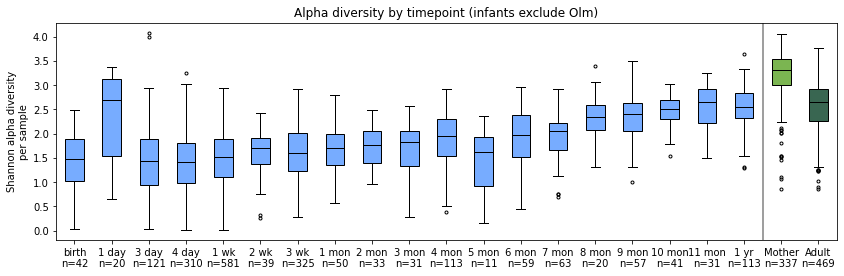

In [11]:
alpha_divs = [] # list of sample values for each tp
labels = []
sample_sizes = []

for tp in infant_tps_ordered:
    num_samples = len(mi_tp_sample_dict['infant'][tp])
    if num_samples < 10:
        continue # Skip timepoints with not enough data
    labels.append(tp + "\n" + ("n=%i" % num_samples))
    alpha_divs_tp = [alpha_div_dict[sample] for sample in mi_tp_sample_dict['infant'][tp]]
    alpha_divs.append(alpha_divs_tp)
    sample_sizes.append(num_samples)


alpha_divs_mother_combined = []
for i in range(len(mother_tps_ordered)):
    tp = mother_tps_ordered[i]
    num_samples = len(mi_tp_sample_dict['mother'][tp])
    alpha_divs_tp = [alpha_div_dict[sample] for sample in mi_tp_sample_dict['mother'][tp]]
    if tp == -92 or tp == 92: # Skip 3month/-3month
        continue
    alpha_divs_mother_combined += alpha_divs_tp

alpha_divs.append(alpha_divs_mother_combined)
labels.append('Mother'+ "\n" + ("n=%i" % len(alpha_divs_mother_combined)))
sample_sizes.append(len(alpha_divs_mother_combined))

alpha_divs_hmp = [alpha_div_dict[sample] for sample in hmp_samples]
alpha_divs.append(alpha_divs_hmp)
labels.append('Adult' + "\n" + ("n=%i" % len(alpha_divs_hmp)))
sample_sizes.append(len(alpha_divs_hmp))

fig, ax = plt.subplots(figsize=(14, 4))

boxprops = dict(color='black')
medianprops = dict(color='black')
flierprops = dict(marker='.')

boxplots = ax.boxplot(alpha_divs, patch_artist=True, boxprops=boxprops, medianprops=medianprops,flierprops=flierprops)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

boxplots['boxes'][-1].set_facecolor('#396651')
boxplots['boxes'][-2].set_facecolor('#7bb551')

ax.set_ylabel("Shannon alpha diversity\nper sample")
ax.set_title("Alpha diversity by timepoint (infants exclude Olm)")
ax.axvline(19.5, color='gray', linestyle='-')
ax.set_xticklabels(labels)

summarize_ttest(alpha_divs[1], alpha_divs[2])

plt.show()


Birth vs. 1 day:
t=-3.6416
P=0.0008047904114401127

1 day vs 3 day:
t=3.1993
P=0.002778845215178916

3 day vs 1 year:
t=-6.9849
P=2.577379701331771e-08


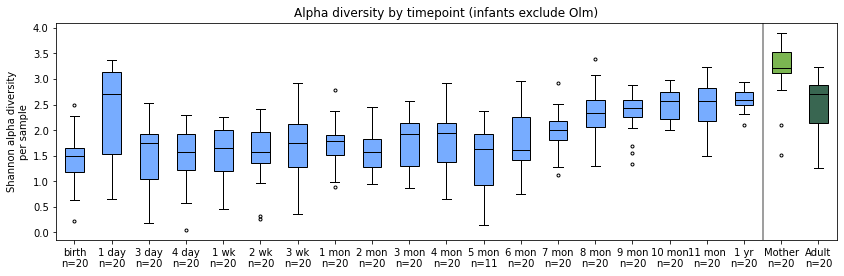

In [17]:
# Try downsampling hosts to 20 (second lowest number besides 5 months)

alpha_divs = [] # list of sample values for each tp
labels = []
sample_sizes = []
subject_sizes = []

for tp in infant_tps_ordered:
    num_samples = len(mi_tp_sample_dict['infant'][tp])
    if num_samples < 10:
        continue # Skip timepoints with not enough data
    
    subjects = set()
    for sample in mi_tp_sample_dict['infant'][tp]:
        subject = sample_subject_map[sample]
        subjects.add(subject)
    
    if num_samples < 20:
        subjects_downsampled = subjects
    else:
        subjects_downsampled = np.random.choice(list(subjects), 20, replace=False)
    
    # Use downsampled subjects
    alpha_divs_tp = []
    for sample in mi_tp_sample_dict['infant'][tp]:
        if sample_subject_map[sample] in subjects_downsampled:
            alpha_divs_tp.append(alpha_div_dict[sample])
    
    labels.append(tp + "\n" + ("n=%i" % len(alpha_divs_tp)))
    # alpha_divs_tp = [alpha_div_dict[sample] for sample in mi_tp_sample_dict['infant'][tp]]
    alpha_divs.append(alpha_divs_tp); sample_sizes.append(num_samples); subject_sizes.append(len(subjects_downsampled))

# Mother ====================================================================================
alpha_divs_mother_combined = []
mother_subjects = set()

for i in range(len(mother_tps_ordered)):
    tp = mother_tps_ordered[i]
    num_samples = len(mi_tp_sample_dict['mother'][tp])
    for sample in mi_tp_sample_dict['mother'][tp]:
        subject = sample_subject_map[sample]
        mother_subjects.add(subject)
    # alpha_divs_tp = [alpha_div_dict[sample] for sample in mi_tp_sample_dict['mother'][tp]]
    if tp == -92 or tp == 92: # Skip 3month/-3month
        continue
    # alpha_divs_mother_combined += alpha_divs_tp

mother_subjects_downsampled = np.random.choice(list(mother_subjects), 20, replace=False)    

# Use downsampled subjects
alpha_divs_mother_combined = []

for i in range(len(mother_tps_ordered)):
    tp = mother_tps_ordered[i]
    for sample in mi_tp_sample_dict['mother'][tp]:
        subject = sample_subject_map[sample]
        if subject in mother_subjects_downsampled:
            alpha_divs_mother_combined.append(alpha_div_dict[sample])

alpha_divs.append(alpha_divs_mother_combined)
labels.append('Mother'+ "\n" + ("n=%i" % len(alpha_divs_mother_combined)))
sample_sizes.append(len(alpha_divs_mother_combined))

# HMP ======================================================================================
hmp_subjects = set()
for sample in hmp_samples:
    hmp_subjects.add(sample_subject_map[sample])

hmp_subjects_downsampled = np.random.choice(list(hmp_subjects), 20, replace=False)

# Use downsampled subjects
alpha_divs_hmp = []
subjects_so_far = set()
for sample in hmp_samples:
    subject = sample_subject_map[sample]
    if subject in subjects_so_far:
        continue
    if subject in hmp_subjects_downsampled:
        alpha_divs_hmp.append(alpha_div_dict[sample])
        subjects_so_far.add(subject)

alpha_divs.append(alpha_divs_hmp)
labels.append('Adult' + "\n" + ("n=%i" % len(alpha_divs_hmp)))
sample_sizes.append(len(alpha_divs_hmp))

# Plot =====================================================================================
fig, ax = plt.subplots(figsize=(14, 4))

boxprops = dict(color='black')
medianprops = dict(color='black')
flierprops = dict(marker='.')

boxplots = ax.boxplot(alpha_divs, patch_artist=True, boxprops=boxprops, medianprops=medianprops,flierprops=flierprops)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

boxplots['boxes'][-1].set_facecolor('#396651')
boxplots['boxes'][-2].set_facecolor('#7bb551')

ax.set_ylabel("Shannon alpha diversity\nper sample")
ax.set_title("Alpha diversity by timepoint (infants exclude Olm)")
ax.axvline(19.5, color='gray', linestyle='-')
ax.set_xticklabels(labels)

print('\nBirth vs. 1 day:')
summarize_ttest(alpha_divs[0], alpha_divs[1], simple=True)
print('\n1 day vs 3 day:')
summarize_ttest(alpha_divs[1], alpha_divs[2], simple=True)
print('\n3 day vs 1 year:')
summarize_ttest(alpha_divs[2], alpha_divs[-3], simple=True)

fig.savefig('%s/alpha_div_over_time_downsampled.pdf' % (config.analysis_directory), bbox_inches='tight')
plt.show()

In [11]:
# Try downsampling many times TODO

p1s = []; p2s = []; p3s = []
t1s = []; t2s = []; t3s = []

for _ in range(1000):
    alpha_divs = [] # list of sample values for each tp

    for tp in infant_tps_ordered:
        num_samples = len(mi_tp_sample_dict['infant'][tp])
        if num_samples < 10:
            continue # Skip timepoints with not enough data

        subjects = set()
        for sample in mi_tp_sample_dict['infant'][tp]:
            subject = sample_subject_map[sample]
            subjects.add(subject)

        if num_samples < 20:
            subjects_downsampled = subjects
        else:
            subjects_downsampled = np.random.choice(list(subjects), 20, replace=False)

        # Use downsampled subjects
        alpha_divs_tp = []
        for sample in mi_tp_sample_dict['infant'][tp]:
            if sample_subject_map[sample] in subjects_downsampled:
                alpha_divs_tp.append(alpha_div_dict[sample])

        alpha_divs.append(alpha_divs_tp); sample_sizes.append(num_samples); subject_sizes.append(len(subjects_downsampled))

    # Mother ====================================================================================
    alpha_divs_mother_combined = []
    mother_subjects = set()

    for i in range(len(mother_tps_ordered)):
        tp = mother_tps_ordered[i]
        num_samples = len(mi_tp_sample_dict['mother'][tp])
        for sample in mi_tp_sample_dict['mother'][tp]:
            subject = sample_subject_map[sample]
            mother_subjects.add(subject)
        # alpha_divs_tp = [alpha_div_dict[sample] for sample in mi_tp_sample_dict['mother'][tp]]
        if tp == -92 or tp == 92: # Skip 3month/-3month
            continue
        # alpha_divs_mother_combined += alpha_divs_tp

    mother_subjects_downsampled = np.random.choice(list(mother_subjects), 20, replace=False)    

    # Use downsampled subjects
    alpha_divs_mother_combined = []

    for i in range(len(mother_tps_ordered)):
        tp = mother_tps_ordered[i]
        for sample in mi_tp_sample_dict['mother'][tp]:
            subject = sample_subject_map[sample]
            if subject in mother_subjects_downsampled:
                alpha_divs_mother_combined.append(alpha_div_dict[sample])

    alpha_divs.append(alpha_divs_mother_combined)
    labels.append('Mother'+ "\n" + ("n=%i" % len(alpha_divs_mother_combined)))
    sample_sizes.append(len(alpha_divs_mother_combined))

    # HMP ======================================================================================
    hmp_subjects = set()
    for sample in hmp_samples:
        hmp_subjects.add(sample_subject_map[sample])

    hmp_subjects_downsampled = np.random.choice(list(hmp_subjects), 20, replace=False)

    # Use downsampled subjects
    alpha_divs_hmp = []
    subjects_so_far = set()
    for sample in hmp_samples:
        subject = sample_subject_map[sample]
        if subject in subjects_so_far:
            continue
        if subject in hmp_subjects_downsampled:
            alpha_divs_hmp.append(alpha_div_dict[sample])
            subjects_so_far.add(subject)

    alpha_divs.append(alpha_divs_hmp)
    
    # print('\nBirth vs. 1 day:')
    t, p = scipy.stats.ttest_ind(alpha_divs[0], alpha_divs[1])
    t1s.append(t); p1s.append(p)
    # print('\n1 day vs 3 day:')
    t, p = scipy.stats.ttest_ind(alpha_divs[1], alpha_divs[2])
    t2s.append(t); p2s.append(p)
    # print('\n3 day vs 1 year:')
    t, p = scipy.stats.ttest_ind(alpha_divs[2], alpha_divs[-3])
    t3s.append(t); p3s.append(p)

In [12]:
print(sum(np.array(p1s) >= 0.05))
print(sum(np.array(p2s) >= 0.05))
print(sum(np.array(p3s) >= 0.05))

0
25
0


In [10]:
# Statistical significance to asterisk representation mapping
def get_sig_str(pval):
    if pval <= 0.001:
        return '***'
    elif pval <= 0.01:
        return '**'
    elif pval <= 0.05:
        return '*'
    elif pval > 0.05:
        return 'ns'

9.292369773603253e-08
0.6787496911736907
0.007561421139874913
9.340793028926264e-12
Mothers vs. HMP females
Group 1 size: 337 | Group 2 size: 122
T-statistic: 12.4416
P-value: 8.302093102232552e-31
Cohen's D: 1.314579202026719
Mothers vs. Qin females
Group 1 size: 337 | Group 2 size: 89
T-statistic: 6.6826
P-value: 7.406379721107871e-11
Cohen's D: 0.7964136850891129


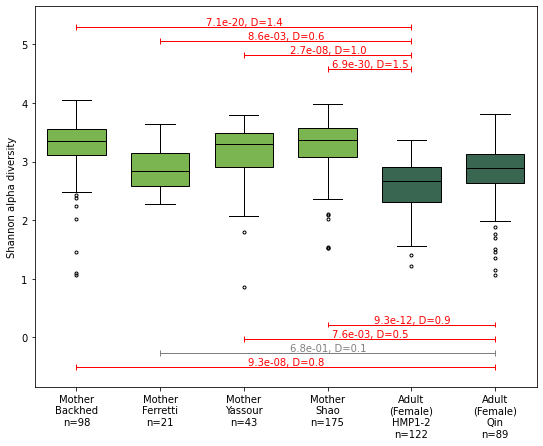

In [26]:
# THIS IS A SUPPLEMENTAL FIGURE
# Compare alpha diversity for Mom from each cohort, HMP1-2, Poyet, Korpela

alpha_divs_mother_by_cohort = defaultdict(list)

sample_cohort_map = su.parse_sample_cohort_map()
mother_samples = su.get_sample_names('mother')
hmp_samples = su.get_sample_names('hmp')
mother_cohorts = ['backhed', 'ferretti', 'yassour', 'shao']

for tp in mother_tps_ordered:
    if tp == -92 or tp == 92: # Skip 3month/-3month
        continue
    for sample in mi_tp_sample_dict['mother'][tp]:
        cohort = sample_cohort_map[sample]
        alpha_div = alpha_div_dict[sample]
        alpha_divs_mother_by_cohort[cohort].append(alpha_div)

alpha_divs = []
alpha_divs_all_mothers = []
labels = []
for cohort in mother_cohorts:
    alpha_divs.append(alpha_divs_mother_by_cohort[cohort])
    alpha_divs_all_mothers += alpha_divs_mother_by_cohort[cohort]
    labels.append('Mother\n%s\nn=%i' % (cohort.capitalize(), len(alpha_divs_mother_by_cohort[cohort])))
'''
hmp_alpha_divs = [alpha_div_dict[sample] for sample in hmp_samples]
alpha_divs.append(hmp_alpha_divs)
labels.append('Adult\nHMP1-2\nn=%i' % (len(hmp_alpha_divs)))
'''
hmp_female_alpha_divs = []
subjects_so_far = set()
for sample in hmp_samples:
    subject = sample_subject_map[sample]
    if subject in subjects_so_far:
        continue
    if subject in hmp_female_subjects:
        hmp_female_alpha_divs.append(alpha_div_dict[sample])
        subjects_so_far.add(subject)
alpha_divs.append(hmp_female_alpha_divs)
labels.append('Adult\n(Female)\nHMP1-2\nn=%i' % (len(hmp_female_alpha_divs)))
'''
alpha_divs.append(list(poyet_alpha_div_dict.values()))
labels.append('Adult\nPoyet\nn=%i' % (len(poyet_alpha_div_dict)))

alpha_divs.append(list(korpela_alpha_div_dict.values()))
labels.append('Adult\nKorpela\nn=%i' % (len(korpela_alpha_div_dict)))

alpha_divs.append(list(qin_alpha_div_dict.values()))
labels.append('Adult\nQin\nn=%i' % (len(qin_alpha_div_dict)))
'''
qin_female_alpha_divs = [qin_alpha_div_dict[sample] for sample in qin_samples \
                  if qin_sample_gender_dict[sample] == 'female']
alpha_divs.append(qin_female_alpha_divs)
labels.append('Adult\n(Female)\nQin\nn=%i' % (len(qin_female_alpha_divs)))


fig, ax = plt.subplots(figsize=(9, 7))

boxprops = dict(color='black')
medianprops = dict(color='black')
flierprops = dict(marker='.')

boxplots = ax.boxplot(alpha_divs, patch_artist=True, boxprops=boxprops, medianprops=medianprops,flierprops=flierprops, widths=0.7)
for patch in boxplots['boxes'][:4]:
    patch.set_facecolor('#7bb551')
for patch in boxplots['boxes'][-2:]:
    patch.set_facecolor('#396651')

# Perform pairwise t-test
j = 0
for i in [0, 1, 2, 3]:
    a1 = alpha_divs[i]
    a2 = alpha_divs[4] # Compare to HMP first
    t, p = scipy.stats.ttest_ind(a1, a2); D = cohenD(a1, a2)    
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax, 5.3 - (0.8*j), i+1, 5, color=color, tickh=0.05)    
    ax.text(1+i+((4-i)/2.0)-0.45, 5.3 - (0.8*j) +0.02, '{:.1e}'.format(p) + (', D=%.01f' % D), color=color)
    # ax[0].text(0.8+i+((4-i)/2.0), 5.3 - j+0.02, '{:.2e}'.format(p), color=color)
    j += 0.3

j = 0
for i in [0, 1, 2, 3]:
    a1 = alpha_divs[i]
    a2 = alpha_divs[5] # Compare to Qin
    t, p = scipy.stats.ttest_ind(a1, a2); D = cohenD(a1, a2)
    print(p)
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax, -0.5 + (0.8*j), i+1, 6, color=color, tickh=0.05)    
    ax.text(1+i+((5-i)/2.0)-0.45, -0.5 + (0.8*j) + 0.02, '{:.1e}'.format(p) + (', D=%.01f' % D), color=color)
    # ax[0].text(0.8+i+((4-i)/2.0), -0.5+j+0.02, '{:.2e}'.format(p), color=color)
    j += 0.3

ax.set_ylabel("Shannon alpha diversity")
# ax.set_title("Alpha diversity of adult samples by cohort")
ax.set_xticklabels(labels)

print("Mothers vs. HMP females")
summarize_ttest(alpha_divs_all_mothers, hmp_female_alpha_divs)
print("Mothers vs. Qin females")
summarize_ttest(alpha_divs_all_mothers, qin_female_alpha_divs)

plt.show()
fig.savefig('%s/alpha_div_mothers_vs_adults_by_cohort.pdf' % (config.analysis_directory), bbox_inches='tight')

Mothers vs. HMP females
Group 1 size: 337 | Group 2 size: 122
T-statistic: 12.4416
P-value: 8.302093102232552e-31
Cohen's D: 1.314579202026719
Mothers vs. Qin females
Group 1 size: 337 | Group 2 size: 89
T-statistic: 6.6826
P-value: 7.406379721107871e-11
Cohen's D: 0.7964136850891129


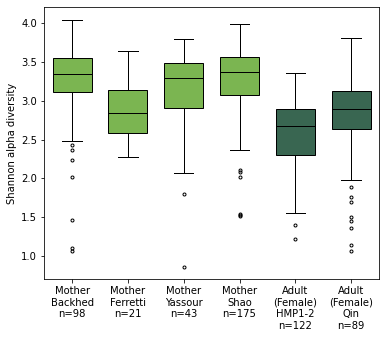

In [13]:
# THIS IS A SUPPLEMENTAL FIGURE
# Compare alpha diversity for Mom from each cohort, HMP1-2, Poyet, Korpela
# This time remove tests

alpha_divs_mother_by_cohort = defaultdict(list)

sample_cohort_map = su.parse_sample_cohort_map()
mother_samples = su.get_sample_names('mother')
hmp_samples = su.get_sample_names('hmp')
mother_cohorts = ['backhed', 'ferretti', 'yassour', 'shao']

for tp in mother_tps_ordered:
    if tp == -92 or tp == 92: # Skip 3month/-3month
        continue
    for sample in mi_tp_sample_dict['mother'][tp]:
        cohort = sample_cohort_map[sample]
        alpha_div = alpha_div_dict[sample]
        alpha_divs_mother_by_cohort[cohort].append(alpha_div)

alpha_divs = []
alpha_divs_all_mothers = []
labels = []
for cohort in mother_cohorts:
    alpha_divs.append(alpha_divs_mother_by_cohort[cohort])
    alpha_divs_all_mothers += alpha_divs_mother_by_cohort[cohort]
    labels.append('Mother\n%s\nn=%i' % (cohort.capitalize(), len(alpha_divs_mother_by_cohort[cohort])))
'''
hmp_alpha_divs = [alpha_div_dict[sample] for sample in hmp_samples]
alpha_divs.append(hmp_alpha_divs)
labels.append('Adult\nHMP1-2\nn=%i' % (len(hmp_alpha_divs)))
'''
hmp_female_alpha_divs = []
subjects_so_far = set()
for sample in hmp_samples:
    subject = sample_subject_map[sample]
    if subject in subjects_so_far:
        continue
    if subject in hmp_female_subjects:
        hmp_female_alpha_divs.append(alpha_div_dict[sample])
        subjects_so_far.add(subject)
alpha_divs.append(hmp_female_alpha_divs)
labels.append('Adult\n(Female)\nHMP1-2\nn=%i' % (len(hmp_female_alpha_divs)))
'''
alpha_divs.append(list(poyet_alpha_div_dict.values()))
labels.append('Adult\nPoyet\nn=%i' % (len(poyet_alpha_div_dict)))

alpha_divs.append(list(korpela_alpha_div_dict.values()))
labels.append('Adult\nKorpela\nn=%i' % (len(korpela_alpha_div_dict)))

alpha_divs.append(list(qin_alpha_div_dict.values()))
labels.append('Adult\nQin\nn=%i' % (len(qin_alpha_div_dict)))
'''
qin_female_alpha_divs = [qin_alpha_div_dict[sample] for sample in qin_samples \
                  if qin_sample_gender_dict[sample] == 'female']
alpha_divs.append(qin_female_alpha_divs)
labels.append('Adult\n(Female)\nQin\nn=%i' % (len(qin_female_alpha_divs)))


fig, ax = plt.subplots(figsize=(6, 5))

boxprops = dict(color='black')
medianprops = dict(color='black')
flierprops = dict(marker='.')

boxplots = ax.boxplot(alpha_divs, patch_artist=True, boxprops=boxprops, medianprops=medianprops,flierprops=flierprops, widths=0.7)
for patch in boxplots['boxes'][:4]:
    patch.set_facecolor('#7bb551')
for patch in boxplots['boxes'][-2:]:
    patch.set_facecolor('#396651')

ax.set_ylabel("Shannon alpha diversity")
# ax.set_title("Alpha diversity of adult samples by cohort")
ax.set_xticklabels(labels)

print("Mothers vs. HMP females")
summarize_ttest(alpha_divs_all_mothers, hmp_female_alpha_divs)
print("Mothers vs. Qin females")
summarize_ttest(alpha_divs_all_mothers, qin_female_alpha_divs)

plt.show()
fig.savefig('%s/alpha_div_mothers_vs_adults_by_cohort_no_tests.pdf' % (config.analysis_directory), bbox_inches='tight')

In [21]:
# Store data for R Q-Q plots

for i, label in zip(np.arange(len(alpha_divs)), ['backhed_mother', 'ferretti_mother', 'yassour_mother', 'shao_mother', 'HMP1-2_female', 'qin_female']):
    with open('%s/alpha_divs_%s.txt' % (config.analysis_directory, label), 'w') as f:
        f.write('\n'.join([str(ad) for ad in alpha_divs[i]]))

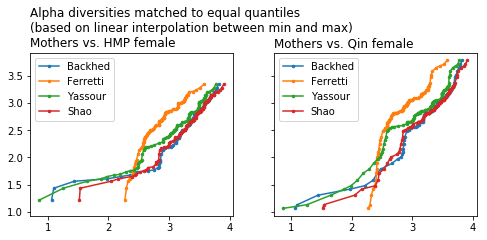

In [22]:
# Fake Q-Q plots to check validity of T test

fig, ax = plt.subplots(1, 2, figsize=(8, 3), 
                       sharey=True)

a = alpha_divs # For brevity
y = [[np.quantile(a[j], i) for i in np.arange(0, 1, step=0.01)] for j in [0, 1, 2, 3, 4, 5]]

# Comparisons to HMP(female)
ax[0].set_title("Alpha diversities matched to equal quantiles\n(based on linear interpolation between min and max)\nMothers vs. HMP female", loc='left')
ax[0].plot(y[0], y[4], '.-', markersize=5, label="Backhed")
ax[0].plot(y[1], y[4], '.-', markersize=5, label="Ferretti")
ax[0].plot(y[2], y[4], '.-', markersize=5, label="Yassour")
ax[0].plot(y[3], y[4], '.-', markersize=5, label="Shao")
ax[0].legend()

# Comparisons to Qin(female)
ax[1].set_title("Mothers vs. Qin female", loc='left')
ax[1].plot(y[0], y[5], '.-', markersize=5, label="Backhed")
ax[1].plot(y[1], y[5], '.-', markersize=5, label="Ferretti")
ax[1].plot(y[2], y[5], '.-', markersize=5, label="Yassour")
ax[1].plot(y[3], y[5], '.-', markersize=5, label="Shao")
ax[1].legend()


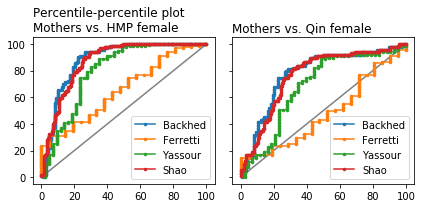

In [23]:
# Actual Q-Q plots to check validity of T test

fig, ax = plt.subplots(1, 2, figsize=(6, 3), 
                       sharey=True)

a = alpha_divs # For brevity

# Comparisons to HMP(female)

ax[0].plot(np.arange(100), np.arange(100), '-', color='gray')
ax[0].set_title("Percentile-percentile plot\nMothers vs. HMP female", loc='left')
y = [[stats.percentileofscore(a[j], val) for val in sorted(a[0]+a[4])] for j in [0, 4]]; ax[0].plot(y[0], y[1], '.-', markersize=5, label="Backhed")
y = [[stats.percentileofscore(a[j], val) for val in sorted(a[1]+a[4])] for j in [1, 4]]; ax[0].plot(y[0], y[1], '.-', markersize=5, label="Ferretti")
y = [[stats.percentileofscore(a[j], val) for val in sorted(a[2]+a[4])] for j in [2, 4]]; ax[0].plot(y[0], y[1], '.-', markersize=5, label="Yassour")
y = [[stats.percentileofscore(a[j], val) for val in sorted(a[3]+a[4])] for j in [3, 4]]; ax[0].plot(y[0], y[1], '.-', markersize=5, label="Shao")
ax[0].legend()

ax[1].plot(np.arange(100), np.arange(100), '-', color='gray')
ax[1].set_title("Mothers vs. Qin female", loc='left')
y = [[stats.percentileofscore(a[j], val) for val in sorted(a[0]+a[5])] for j in [0, 5]]; ax[1].plot(y[0], y[1], '.-', markersize=5, label="Backhed")
y = [[stats.percentileofscore(a[j], val) for val in sorted(a[1]+a[5])] for j in [1, 5]]; ax[1].plot(y[0], y[1], '.-', markersize=5, label="Ferretti")
y = [[stats.percentileofscore(a[j], val) for val in sorted(a[2]+a[5])] for j in [2, 5]]; ax[1].plot(y[0], y[1], '.-', markersize=5, label="Yassour")
y = [[stats.percentileofscore(a[j], val) for val in sorted(a[3]+a[5])] for j in [3, 5]]; ax[1].plot(y[0], y[1], '.-', markersize=5, label="Shao")
ax[1].legend()

plt.tight_layout()

(array([ 2.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  2.,  0.,  6.,  5.,
         7., 16., 24., 15., 12.,  4.,  1.]),
 array([1.06435988, 1.21360294, 1.362846  , 1.51208906, 1.66133212,
        1.81057518, 1.95981824, 2.1090613 , 2.25830436, 2.40754742,
        2.55679048, 2.70603354, 2.8552766 , 3.00451966, 3.15376272,
        3.30300578, 3.45224884, 3.6014919 , 3.75073496, 3.89997802,
        4.04922108]),
 <a list of 20 Patch objects>)

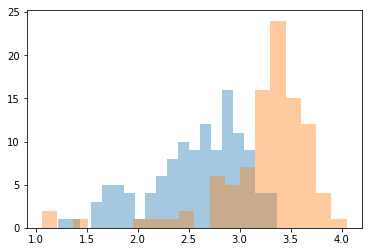

In [24]:
fig, ax = plt.subplots()
ax.hist(a[4], bins=20, label='HMP(Female)', alpha=0.4)
ax.hist(a[0], bins=20, label='Backhed(Mother)', alpha=0.4)

In [15]:
# Store polymorphism CSV for GLMM analysis

f = open('%s/polymorphism.csv' % config.analysis_directory, 'w')
f.write(','.join(['sample', 'species', 'subject', 'cohort', 'day', 'polymorphism']) + '\n')

for sample in infant_samples:
    cohort = sample_cohort_map[sample]
    subject = sample_subject_map[sample]
    day = mi_sample_day_dict[sample]
    feeding_mode = subject_feeding_mode_map[subject] if subject in subject_feeding_mode_map else 'NA'
    delivery_mode = subject_delivery_mode_map[subject] if subject in subject_delivery_mode_map else 'NA'
    for species in sample_species_polymorphism_dict[sample]:
        polymorphism = sample_species_polymorphism_dict[sample][species]
        f.write(','.join([str(val) for val in [sample, species, subject, cohort, day, polymorphism]]) + '\n')

f.close()

In [16]:
# Store polymorphism CSV for GLMM analysis: UPDATED

f = open('%s/polymorphism.csv' % config.analysis_directory, 'w')
f.write(','.join(['sample', 'species', 'subject', 'cohort', 'day', 'polymorphism', 'breast', 'formula', 'vaginal', 'csection']) + '\n')

for sample in infant_samples:
    cohort = sample_cohort_map[sample]
    subject = sample_subject_map[sample]
    day = mi_sample_day_dict[sample]
    feeding_mode = subject_feeding_mode_map[subject] if subject in subject_feeding_mode_map else 'NA'
    
    if feeding_mode == 'breast':
        breast = 1; formula = 0
    elif feeding_mode == 'mixed':
        breast = 1; formula = 1
    elif feeding_mode == 'formula':
        breast = 0; formula = 1
    else:
        breast = 'NA'; formula = 'NA'
    
    delivery_mode = subject_delivery_mode_map[subject] if subject in subject_delivery_mode_map else 'NA'
    if delivery_mode == 'Vaginal':
        vaginal = 1; csection = 0
    elif delivery_mode == 'C-section':
        vaginal = 0; csection = 1
    else:
        vaginal = 'NA'; csection = 'NA'
    
    for species in sample_species_polymorphism_dict[sample]:
        polymorphism = sample_species_polymorphism_dict[sample][species]
        f.write(','.join([str(val) for val in [sample, species, subject, cohort, day, polymorphism, breast, formula, vaginal, csection]]) + '\n')

f.close()

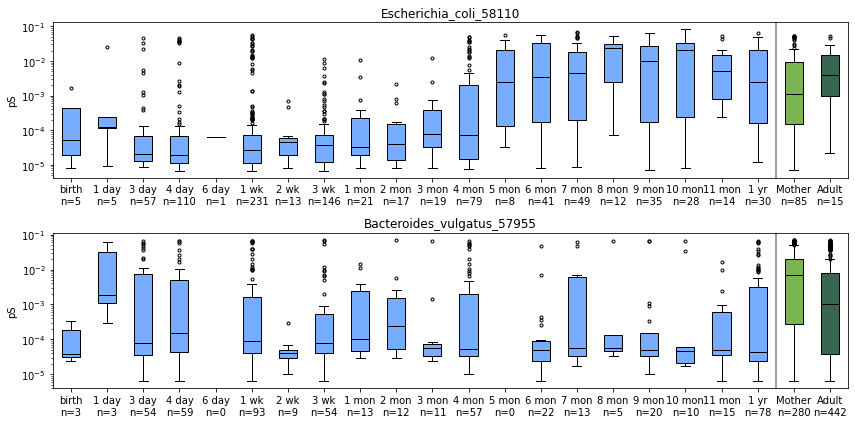

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))

species_list = good_species_list[0:2]

all_tps = tps_ordered_dict['infant'] + ['Mother', 'Adult']

for i in range(len(species_list)):
    desired_species = species_list[i]
    data = []
    labels = []
    
    polymorphism_by_tp_dict = defaultdict(list)
    
    for sample in mother_samples:
        for species in sample_species_polymorphism_dict[sample]:
            polymorphism = sample_species_polymorphism_dict[sample][species]
            if species == desired_species:
                polymorphism_by_tp_dict['Mother'].append(polymorphism)
    
    for sample in hmp_samples:
        for species in sample_species_polymorphism_dict[sample]:
            polymorphism = sample_species_polymorphism_dict[sample][species]
            if species == desired_species:
                polymorphism_by_tp_dict['Adult'].append(polymorphism)
    
    for tp in mi_tp_sample_dict['infant']:
        for sample in mi_tp_sample_dict['infant'][tp]:
            for species in sample_species_polymorphism_dict[sample]:
                polymorphism = sample_species_polymorphism_dict[sample][species]
                if species == desired_species:
                    polymorphism_by_tp_dict[tp].append(polymorphism)
    
    for tp in all_tps:
        polymorphisms = polymorphism_by_tp_dict[tp]
        data.append(polymorphisms)
        labels.append("%s\nn=%i" % (tp, len(polymorphisms)))
    
    ax[i].set_yscale('log')
    boxprops = dict(color='black')
    medianprops = dict(color='black')
    flierprops = dict(marker='.')
    boxplots = ax[i].boxplot(data, patch_artist=True, 
                             boxprops=boxprops,
                             medianprops=medianprops,
                             flierprops=flierprops)
    for patch in boxplots['boxes'][:-2]:
        patch.set_facecolor('#77acff')
    boxplots['boxes'][-1].set_facecolor('#396651')
    boxplots['boxes'][-2].set_facecolor('#7bb551')
    ax[i].set_title('%s' % desired_species)
    ax[i].axvline(x=20.5, color='gray')
    ax[i].set_ylabel("pS")
    ax[i].set_xticklabels(labels)

plt.tight_layout()
plt.show()

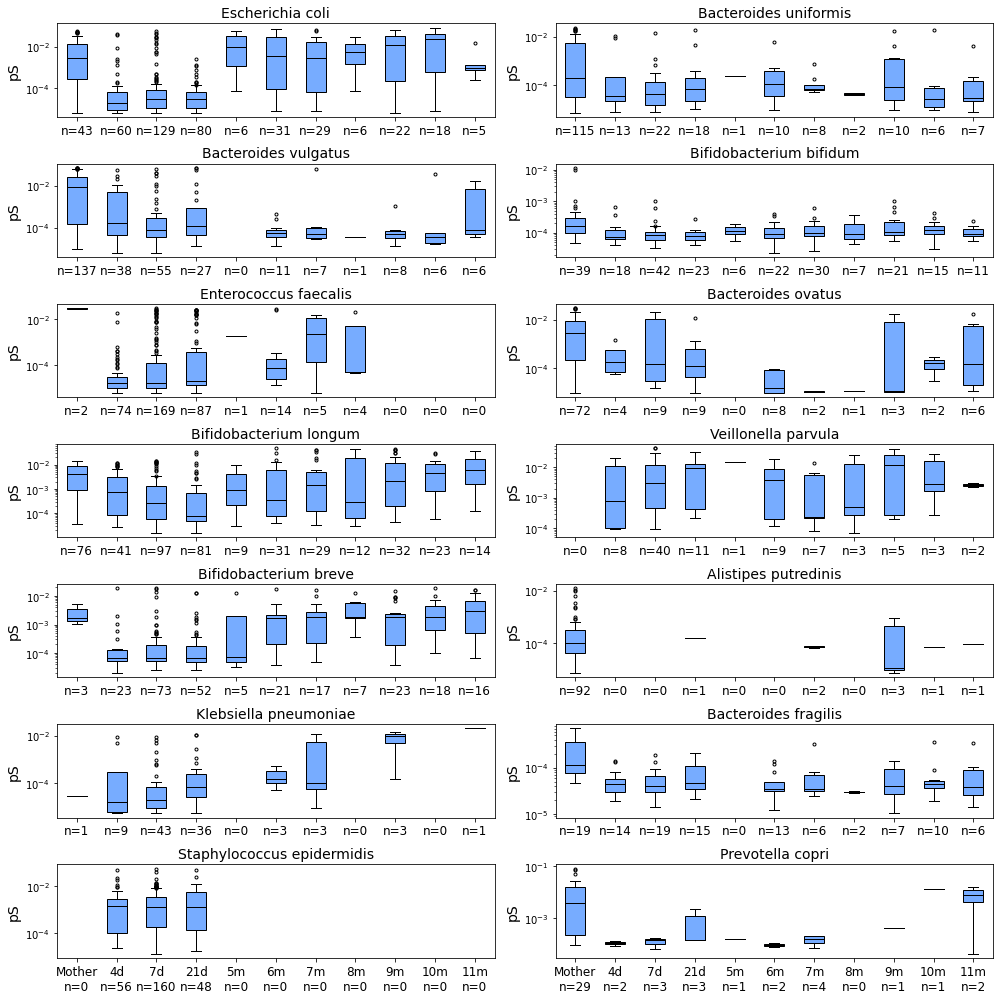

In [32]:
fig, ax = plt.subplots(7, 2, figsize=(14,14)) # , sharex=True)

species_list = good_species_list[0:14] # species_infant_prev_ordered[:3] + species_infant_prev_ordered[4:13]

# Shao
month_bins = np.arange(4, 15) * 30.5
order_bins = [0, 4, 7, 21] + list(month_bins[1:8]) # Limit to the desired timepoint bins only
shao_samples = su.get_sample_names('Shao')

i = 0; j = 0
for desired_species in species_list:
    
    order_polymorphism_dict = defaultdict(list)
    order_subjects_dict = defaultdict(set)
    
    for sample in shao_samples:
        subject, order = sample_order_map[sample]
        if subject in order_subjects_dict[tp]: # Ensure one sample per subject for particular timepoint bin
            continue

        if desired_species in sample_species_polymorphism_dict[sample]:
            polymorphism = sample_species_polymorphism_dict[sample][desired_species]
        else:
            continue
        
        if subject[-1] == 'M': # Mother
            order_polymorphism_dict[0].append(polymorphism)
        elif order > 21: # Convert to month bins
            month_bin = round_down(order, 30.5)
            order_polymorphism_dict[month_bin].append(polymorphism)
        else:
            order_polymorphism_dict[order].append(polymorphism)

        order_subjects_dict[tp].add(subject)
    
    plot_data = [order_polymorphism_dict[o] for o in order_bins] # if len(order_polymorphism_dict[o]) > 5]
    order_labels = ['Mother', '4d', '7d', '21d', '5m', '6m', '7m', '8m', '9m', '10m', '11m']
    n_labels = ['n=%i' % len(order_polymorphism_dict[o]) for o in order_bins]
    # n_labels = [('n=%i' % len(order_polymorphism_dict[o]) if len(order_polymorphism_dict[o]) > 0 else '') for o in order_bins]
    order_labels_with_n = [label + '\nn=%i' % len(order_polymorphism_dict[o]) for label, o in zip(order_labels, order_bins)] # if len(order_polymorphism_dict[o]) > 5]
    
    ax[i][j].set_yscale('log')
    boxplots = ax[i][j].boxplot(plot_data, patch_artist=True, boxprops=boxprops, medianprops=medianprops, flierprops=flierprops)
    for patch in boxplots['boxes']:
        patch.set_facecolor('#77acff')
    
    ax[i][j].set_ylabel("Polymorphism")
    ax[i][j].set_title('%s' % plot_utils.get_pretty_species_name(desired_species), fontsize=14)
    ax[i][j].set_ylabel("pS", fontsize=14)
    ax[i][j].set_xticks(np.arange(1, len(order_labels_with_n)+1))
    if i == 6:
        ax[i][j].set_xticklabels(order_labels_with_n, fontsize=12)
    else:
        ax[i][j].set_xticklabels(n_labels, fontsize=12)
    
    if i < 7:
        i += 1
    
    if i == 7:
        i = 0
        j = 1

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

fig.savefig('%s/polymorphism_top_14_prevalence_species_Shao_only.pdf' % (config.analysis_directory), bbox_inches='tight')
fig.savefig('%s/polymorphism_top_14_prevalence_species_Shao_only.png' % (config.analysis_directory), bbox_inches='tight', dpi=500)


Birth vs. 1 day:
t=-0.9348
P=0.3772518248379395

1 day vs 3 day:
t=0.1593
P=0.8763210971499628

3 day vs 1 year:
t=-0.6309
P=0.5382852555988726


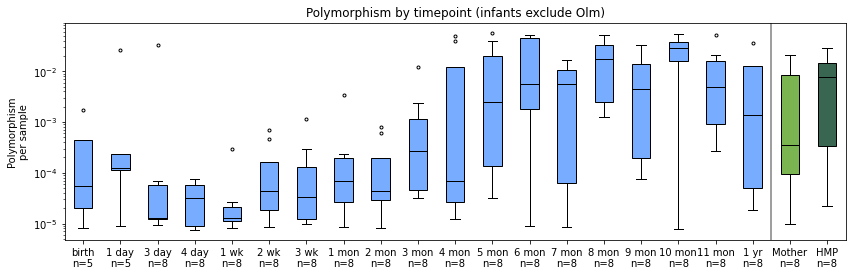

In [43]:
# Try downsampling hosts to 8 (second lowest number besides birth, one day)
# Now for E. coli

desired_species = 'Escherichia_coli_58110'

polymorphisms = [] # list of sample values for each tp
labels = []; sample_sizes = []; subject_sizes = []    

for tp in infant_tps_ordered:
    num_samples = len(mi_tp_sample_dict['infant'][tp])
    if num_samples < 10:
        continue # Skip timepoints with not enough data
    
    subjects = set()
    for sample in mi_tp_sample_dict['infant'][tp]:
        if desired_species in sample_species_polymorphism_dict[sample]:
            subject = sample_subject_map[sample]
            subjects.add(subject)
    
    if len(subjects) < 8:
        subjects_downsampled = subjects
    else:
        subjects_downsampled = np.random.choice(list(subjects), 8, replace=False)
    
    # Use downsampled subjects
    polymorphisms_tp = []
    for sample in mi_tp_sample_dict['infant'][tp]:
        if sample_subject_map[sample] in subjects_downsampled and desired_species in sample_species_polymorphism_dict[sample]:
            polymorphism = sample_species_polymorphism_dict[sample][desired_species]
            polymorphisms_tp.append(polymorphism)
    
    labels.append(tp + "\n" + ("n=%i" % len(polymorphisms_tp)))
    polymorphisms.append(polymorphisms_tp) # sample_sizes.append(num_samples); subject_sizes.append(len(subjects_downsampled))

# Mother ====================================================================================
polymorphisms_mother_combined = []
mother_subjects = set()

for tp in mother_tps_ordered:
    if tp == -92 or tp == 92: # Skip 3month/-3month
        continue
    for sample in mi_tp_sample_dict['mother'][tp]:
        if desired_species in sample_species_polymorphism_dict[sample]:
            subject = sample_subject_map[sample]
            mother_subjects.add(subject)

mother_subjects_downsampled = np.random.choice(list(mother_subjects), 8, replace=False)    

# Use downsampled subjects
polymorphisms_mother_combined = []
for tp in mother_tps_ordered:
    for sample in mi_tp_sample_dict['mother'][tp]:
        if sample_subject_map[sample] in mother_subjects_downsampled and desired_species in sample_species_polymorphism_dict[sample]:
            polymorphism = sample_species_polymorphism_dict[sample][desired_species]
            polymorphisms_mother_combined.append(polymorphism)

labels.append('Mother'+ "\n" + ("n=%i" % len(polymorphisms_mother_combined)))
polymorphisms.append(polymorphisms_mother_combined)

# HMP ======================================================================================
hmp_subjects = set()
for sample in hmp_samples:
    if desired_species in sample_species_polymorphism_dict[sample]:
        hmp_subjects.add(sample_subject_map[sample])

hmp_subjects_downsampled = np.random.choice(list(hmp_subjects), 8, replace=False)

# Use downsampled subjects
polymorphisms_hmp = []
subjects_so_far = set()
for sample in hmp_samples:
    subject = sample_subject_map[sample]
    if desired_species in sample_species_polymorphism_dict[sample]:    
        if subject in subjects_so_far:
            continue
        if subject in hmp_subjects_downsampled:
            polymorphisms_hmp.append(sample_species_polymorphism_dict[sample][desired_species])
            subjects_so_far.add(subject)

labels.append('HMP' + "\n" + ("n=%i" % len(polymorphisms_hmp)))
polymorphisms.append(polymorphisms_hmp)

# Plot =====================================================================================
fig, ax = plt.subplots(figsize=(14, 4))

boxprops = dict(color='black')
medianprops = dict(color='black')
flierprops = dict(marker='.')

boxplots = ax.boxplot(polymorphisms, patch_artist=True, boxprops=boxprops, medianprops=medianprops,flierprops=flierprops)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

boxplots['boxes'][-1].set_facecolor('#396651')
boxplots['boxes'][-2].set_facecolor('#7bb551')

ax.set_ylabel("Polymorphism\nper sample")
ax.set_title("Polymorphism by timepoint (infants exclude Olm)")
ax.axvline(19.5, color='gray', linestyle='-')
ax.set_xticklabels(labels)
ax.set_yscale('log')

print('\nBirth vs. 1 day:')
summarize_ttest(polymorphisms[0], polymorphisms[1], simple=True)
print('\n1 day vs 3 day:')
summarize_ttest(polymorphisms[1], polymorphisms[2], simple=True)
print('\n3 day vs 1 year:')
summarize_ttest(polymorphisms[2], polymorphisms[-3], simple=True)

fig.savefig('%s/polymorphism_over_time_downsampled.pdf' % (config.analysis_directory), bbox_inches='tight')
plt.show()


Alpha diversity - Birth vs. 1 day:
t=-4.0792
P=0.00022311157762644956

Alpha diversity - 1 day vs 3 day:
t=4.0420
P=0.00024927056096208424

Alpha diversity - 3 day vs 1 year:
t=-6.4486
P=1.3830234146524953e-07

Polymorphism - Birth vs. 1 day:
U=10.0000
P=0.6904761904761905

Polymorphism - 1 day vs 3 day:
U=32.0000
P=0.09324009324009325

Polymorphism - 3 day vs 1 year:
U=2.0000
P=0.0006216006216006216


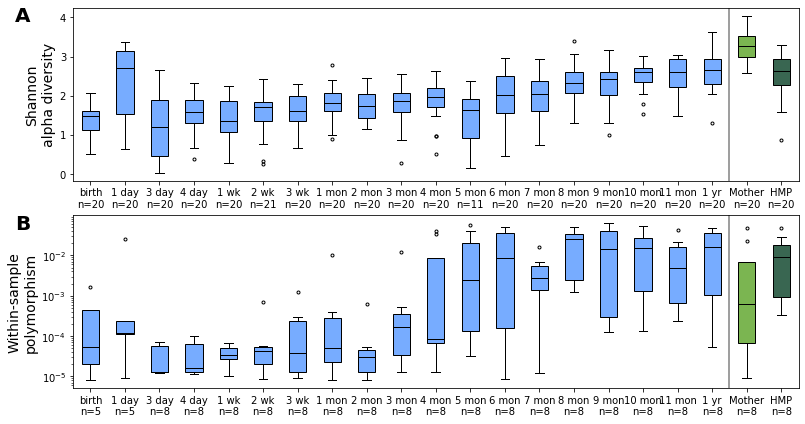

In [49]:
# Combined downsampled alpha diversity and polymorphism plot

fig, ax = plt.subplots(2, 1, figsize=(13,7))
boxprops = dict(color='black'); medianprops = dict(color='black'); flierprops = dict(marker='.')

# Try downsampling hosts to 20 (second lowest number besides 5 months)
# For alpha diversity

alpha_divs = [] # list of sample values for each tp
labels = []
sample_sizes = []
subject_sizes = []

for tp in infant_tps_ordered:
    num_samples = len(mi_tp_sample_dict['infant'][tp])
    if num_samples < 10:
        continue # Skip timepoints with not enough data
    
    subjects = set()
    for sample in mi_tp_sample_dict['infant'][tp]:
        subject = sample_subject_map[sample]
        subjects.add(subject)
    
    if num_samples < 20:
        subjects_downsampled = subjects
    else:
        subjects_downsampled = np.random.choice(list(subjects), 20, replace=False)
    
    # Use downsampled subjects
    alpha_divs_tp = []
    for sample in mi_tp_sample_dict['infant'][tp]:
        if sample_subject_map[sample] in subjects_downsampled:
            alpha_divs_tp.append(alpha_div_dict[sample])
    
    labels.append(tp + "\n" + ("n=%i" % len(alpha_divs_tp)))
    # alpha_divs_tp = [alpha_div_dict[sample] for sample in mi_tp_sample_dict['infant'][tp]]
    alpha_divs.append(alpha_divs_tp); sample_sizes.append(num_samples); subject_sizes.append(len(subjects_downsampled))

# Mother ====================================================================================
alpha_divs_mother_combined = []
mother_subjects = set()

for i in range(len(mother_tps_ordered)):
    tp = mother_tps_ordered[i]
    num_samples = len(mi_tp_sample_dict['mother'][tp])
    for sample in mi_tp_sample_dict['mother'][tp]:
        subject = sample_subject_map[sample]
        mother_subjects.add(subject)
    # alpha_divs_tp = [alpha_div_dict[sample] for sample in mi_tp_sample_dict['mother'][tp]]
    if tp == -92 or tp == 92: # Skip 3month/-3month
        continue
    # alpha_divs_mother_combined += alpha_divs_tp

mother_subjects_downsampled = np.random.choice(list(mother_subjects), 20, replace=False)    

# Use downsampled subjects
alpha_divs_mother_combined = []

for i in range(len(mother_tps_ordered)):
    tp = mother_tps_ordered[i]
    for sample in mi_tp_sample_dict['mother'][tp]:
        subject = sample_subject_map[sample]
        if subject in mother_subjects_downsampled:
            alpha_divs_mother_combined.append(alpha_div_dict[sample])

alpha_divs.append(alpha_divs_mother_combined)
labels.append('Mother'+ "\n" + ("n=%i" % len(alpha_divs_mother_combined)))
sample_sizes.append(len(alpha_divs_mother_combined))

# HMP ======================================================================================
hmp_subjects = set()
for sample in hmp_samples:
    hmp_subjects.add(sample_subject_map[sample])

hmp_subjects_downsampled = np.random.choice(list(hmp_subjects), 20, replace=False)

# Use downsampled subjects
alpha_divs_hmp = []
subjects_so_far = set()
for sample in hmp_samples:
    subject = sample_subject_map[sample]
    if subject in subjects_so_far:
        continue
    if subject in hmp_subjects_downsampled:
        alpha_divs_hmp.append(alpha_div_dict[sample])
        subjects_so_far.add(subject)

alpha_divs.append(alpha_divs_hmp)
labels.append('HMP' + "\n" + ("n=%i" % len(alpha_divs_hmp)))
sample_sizes.append(len(alpha_divs_hmp))

# Plot =====================================================================================
boxplots = ax[0].boxplot(alpha_divs, patch_artist=True, boxprops=boxprops, medianprops=medianprops,flierprops=flierprops)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

boxplots['boxes'][-1].set_facecolor('#396651')
boxplots['boxes'][-2].set_facecolor('#7bb551')

ax[0].set_ylabel("Shannon\nalpha diversity", fontsize=14)
ax[0].axvline(19.5, color='gray', linestyle='-')
ax[0].set_xticklabels(labels)
ax[0].text(-0.08, 0.92, 'A', size=20, transform=ax[0].transAxes, weight='bold')

print('\nAlpha diversity - Birth vs. 1 day:')
summarize_ttest(alpha_divs[0], alpha_divs[1], simple=True)
print('\nAlpha diversity - 1 day vs 3 day:')
summarize_ttest(alpha_divs[1], alpha_divs[2], simple=True)
print('\nAlpha diversity - 3 day vs 1 year:')
summarize_ttest(alpha_divs[2], alpha_divs[-3], simple=True)

# Now polymorphism
desired_species = 'Escherichia_coli_58110'

polymorphisms = [] # list of sample values for each tp
labels = []; sample_sizes = []; subject_sizes = []    

for tp in infant_tps_ordered:
    num_samples = len(mi_tp_sample_dict['infant'][tp])
    if num_samples < 10:
        continue # Skip timepoints with not enough data
    
    subjects = set()
    for sample in mi_tp_sample_dict['infant'][tp]:
        if desired_species in sample_species_polymorphism_dict[sample]:
            subject = sample_subject_map[sample]
            subjects.add(subject)
    
    if len(subjects) < 8:
        subjects_downsampled = subjects
    else:
        subjects_downsampled = np.random.choice(list(subjects), 8, replace=False)
    
    # Use downsampled subjects
    polymorphisms_tp = []
    for sample in mi_tp_sample_dict['infant'][tp]:
        if sample_subject_map[sample] in subjects_downsampled and desired_species in sample_species_polymorphism_dict[sample]:
            polymorphism = sample_species_polymorphism_dict[sample][desired_species]
            polymorphisms_tp.append(polymorphism)
    
    labels.append(tp + "\n" + ("n=%i" % len(polymorphisms_tp)))
    polymorphisms.append(polymorphisms_tp) # sample_sizes.append(num_samples); subject_sizes.append(len(subjects_downsampled))

# Mother ====================================================================================
polymorphisms_mother_combined = []
mother_subjects = set()

for tp in mother_tps_ordered:
    if tp == -92 or tp == 92: # Skip 3month/-3month
        continue
    for sample in mi_tp_sample_dict['mother'][tp]:
        if desired_species in sample_species_polymorphism_dict[sample]:
            subject = sample_subject_map[sample]
            mother_subjects.add(subject)

mother_subjects_downsampled = np.random.choice(list(mother_subjects), 8, replace=False)    

# Use downsampled subjects
polymorphisms_mother_combined = []
for tp in mother_tps_ordered:
    for sample in mi_tp_sample_dict['mother'][tp]:
        if sample_subject_map[sample] in mother_subjects_downsampled and desired_species in sample_species_polymorphism_dict[sample]:
            polymorphism = sample_species_polymorphism_dict[sample][desired_species]
            polymorphisms_mother_combined.append(polymorphism)

labels.append('Mother'+ "\n" + ("n=%i" % len(polymorphisms_mother_combined)))
polymorphisms.append(polymorphisms_mother_combined)

# HMP ======================================================================================
hmp_subjects = set()
for sample in hmp_samples:
    if desired_species in sample_species_polymorphism_dict[sample]:
        hmp_subjects.add(sample_subject_map[sample])

hmp_subjects_downsampled = np.random.choice(list(hmp_subjects), 8, replace=False)

# Use downsampled subjects
polymorphisms_hmp = []
subjects_so_far = set()
for sample in hmp_samples:
    subject = sample_subject_map[sample]
    if desired_species in sample_species_polymorphism_dict[sample]:    
        if subject in subjects_so_far:
            continue
        if subject in hmp_subjects_downsampled:
            polymorphisms_hmp.append(sample_species_polymorphism_dict[sample][desired_species])
            subjects_so_far.add(subject)

labels.append('HMP' + "\n" + ("n=%i" % len(polymorphisms_hmp)))
polymorphisms.append(polymorphisms_hmp)

# Plot =====================================================================================
boxplots = ax[1].boxplot(polymorphisms, patch_artist=True, boxprops=boxprops, medianprops=medianprops,flierprops=flierprops)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

boxplots['boxes'][-1].set_facecolor('#396651')
boxplots['boxes'][-2].set_facecolor('#7bb551')

ax[1].axvline(x=19.5, color='gray')
ax[1].set_ylabel("Within-sample\npolymorphism", fontsize=14)
ax[1].set_xticklabels(labels)
ax[1].set_yscale('log')
ax[1].text(-0.08, 0.92, 'B', size=20, transform=ax[1].transAxes, weight='bold')

polymorphisms_before_4m = []
for polymorphisms_tp in polymorphisms[:10]:
    polymorphisms_before_4m += polymorphisms_tp

polymorphisms_after_incl_4m = []
for polymorphisms_tp in polymorphisms[10:-2]:
    polymorphisms_after_incl_4m += polymorphisms_tp

print('\nPolymorphism - before vs after/including 4 months:')
summarize_utest(polymorphisms_before_4m, polymorphisms_after_incl_4m, simple=True)

fig.savefig('%s/alpha_div_and_polymorphism_over_time_downsampled.pdf' % (config.analysis_directory), bbox_inches='tight')
plt.show()

In [67]:
# Freeze the data
pickle.dump(polymorphisms, open('%s/polymorphisms_downsampled_8_subjects.pkl' % pickle_dir, 'wb'))
pickle.dump(alpha_divs, open('%s/alpha_divs_downsampled_20_subjects.pkl' % pickle_dir, 'wb'))

In [63]:
# Check statistics again without regenerating the data

print('\nAlpha diversity - Birth vs. 1 day:')
summarize_ttest(alpha_divs[0], alpha_divs[1], simple=True)
print('\nAlpha diversity - 1 day vs 3 day:')
summarize_ttest(alpha_divs[1], alpha_divs[2], simple=True)
print('\nAlpha diversity - 3 day vs 1 year:')
summarize_ttest(alpha_divs[2], alpha_divs[-3], simple=True)

polymorphisms_before_4m = []
for polymorphisms_tp in polymorphisms[:10]:
    polymorphisms_before_4m += polymorphisms_tp

polymorphisms_after_incl_4m = []
for polymorphisms_tp in polymorphisms[10:-2]:
    polymorphisms_after_incl_4m += polymorphisms_tp

print('\nPolymorphism - before vs after/including 4 months:')
summarize_utest(polymorphisms_before_4m, polymorphisms_after_incl_4m, simple=True)


Alpha diversity - Birth vs. 1 day:
t=-4.0792
P=0.00022311157762644956
d=-1.2899466761613536

Alpha diversity - 1 day vs 3 day:
t=4.0420
P=0.00024927056096208424
d=1.278185260481769

Alpha diversity - 3 day vs 1 year:
t=-6.4486
P=1.3830234146524953e-07
d=-2.039232996757948

Polymorphism - before vs after/including 4 months:
U=634.0000
P=1.9577319051189918e-15
Effect size: 0.6574496149109467


In [57]:
labels[10:-2]

['4 mon\nn=8',
 '5 mon\nn=8',
 '6 mon\nn=8',
 '7 mon\nn=8',
 '8 mon\nn=8',
 '9 mon\nn=8',
 '10 mon\nn=8',
 '11 mon\nn=8',
 '1 yr\nn=8']

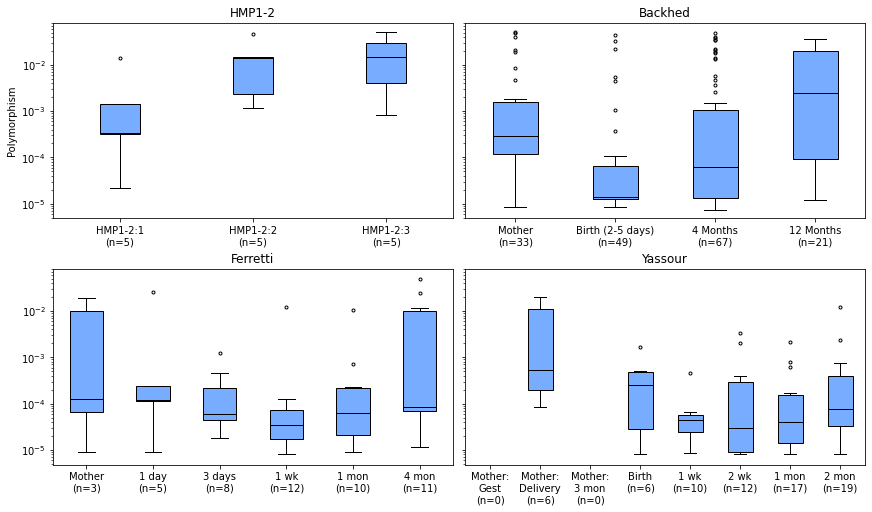

In [19]:
# Split E. coli polymorphism by dataset

# fig, ax = plt.subplots(1, 4, figsize=(18,4), sharey=True, constrained_layout=True,
#                       gridspec_kw={'width_ratios': [2, 3, 3, 3]})
fig, ax = plt.subplots(2,2, figsize=(12,7), sharey=True, constrained_layout=True)
desired_species = 'Escherichia_coli_58110'

# HMP1-2
hmp_samples = su.get_sample_names('HMP')
order_polymorphism_dict = defaultdict(list)
for sample in hmp_samples:
    subject, order = sample_order_map[sample]
    if desired_species in sample_species_polymorphism_dict[sample]:
        polymorphism = sample_species_polymorphism_dict[sample][desired_species]
        order_polymorphism_dict[order].append(polymorphism)

order_list = [1, 2, 3]
order_labels = ['HMP1-2:1', 'HMP1-2:2', 'HMP1-2:3']
order_labels_with_n = [label + '\n(n=%i)' % len(order_polymorphism_dict[o]) for label, o in zip(order_labels, order_list)]

plot_data = [order_polymorphism_dict[o] for o in order_list]

ax[0][0].set_yscale('log')
boxplots = ax[0][0].boxplot(plot_data, patch_artist=True, 
                 boxprops=boxprops, 
                 medianprops=medianprops,
                 flierprops=flierprops)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')
ax[0][0].set_xticklabels(order_labels_with_n)
ax[0][0].set_ylabel("Polymorphism")
ax[0][0].set_title("HMP1-2")

# Backhed
backhed_samples = su.get_sample_names('Backhed')
order_polymorphism_dict = defaultdict(list)
for sample in backhed_samples:
    tp = su.sample_to_tp(sample, sample_order_map, hmp_samples, mother_samples)    
    if desired_species in sample_species_polymorphism_dict[sample]:
        polymorphism = sample_species_polymorphism_dict[sample][desired_species]
        order_polymorphism_dict[tp].append(polymorphism)

order_list = ['M1', 'I1', 'I2', 'I3']
order_labels = ['Mother', 'Birth (2-5 days)', '4 Months', '12 Months']
order_labels_with_n = [label + '\n(n=%i)' % len(order_polymorphism_dict[o]) for label, o in zip(order_labels, order_list)]

plot_data = [order_polymorphism_dict[o] for o in order_list]

ax[0][1].set_yscale('log')
boxplots = ax[0][1].boxplot(plot_data, patch_artist=True, 
                 boxprops=boxprops, 
                 medianprops=medianprops,
                 flierprops=flierprops)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')
ax[0][1].set_xticklabels(order_labels_with_n)
ax[0][1].set_title("Backhed")

# Ferretti
ferretti_samples = su.get_sample_names('Ferretti')
order_polymorphism_dict = defaultdict(list)
for sample in ferretti_samples:
    tp = su.sample_to_tp(sample, sample_order_map, hmp_samples, mother_samples)
    if desired_species in sample_species_polymorphism_dict[sample]:
        polymorphism = sample_species_polymorphism_dict[sample][desired_species]
        order_polymorphism_dict[tp].append(polymorphism)

order_list = ['M1', 'I1', 'I2', 'I3', 'I4', 'I5']
order_labels = ['Mother', '1 day', '3 days', '1 wk', '1 mon', '4 mon']
order_labels_with_n = [label + '\n(n=%i)' % len(order_polymorphism_dict[o]) for label, o in zip(order_labels, order_list)]

plot_data = [order_polymorphism_dict[o] for o in order_list]

ax[1][0].set_yscale('log')
boxplots = ax[1][0].boxplot(plot_data, patch_artist=True, 
                 boxprops=boxprops, 
                 medianprops=medianprops,
                 flierprops=flierprops)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')
ax[1][0].set_xticklabels(order_labels_with_n)
ax[1][0].set_title("Ferretti")

# Yassour
yassour_samples = su.get_sample_names('Yassour')
order_polymorphism_dict = defaultdict(list)
for sample in yassour_samples:
    tp = su.sample_to_tp(sample, sample_order_map, hmp_samples, mother_samples)
    if desired_species in sample_species_polymorphism_dict[sample]:
        polymorphism = sample_species_polymorphism_dict[sample][desired_species]
        order_polymorphism_dict[tp].append(polymorphism)

order_list = ['M1', 'M2', 'M3', 'I1', 'I2', 'I3', 'I4', 'I5']
order_labels = ['Mother:\nGest', 'Mother:\nDelivery','Mother:\n3 mon', 'Birth', '1 wk', '2 wk', '1 mon', '2 mon', '3 mon']
order_labels_with_n = [label + '\n(n=%i)' % len(order_polymorphism_dict[o]) for label, o in zip(order_labels, order_list)]

plot_data = [order_polymorphism_dict[o] for o in order_list]

ax[1][1].set_yscale('log')
boxplots = ax[1][1].boxplot(plot_data, patch_artist=True, 
                 boxprops=boxprops, 
                 medianprops=medianprops,
                 flierprops=flierprops)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')
ax[1][1].set_xticklabels(order_labels_with_n)
ax[1][1].set_title("Yassour")

plt.show()

Text(0.5, 1.0, 'Shao')

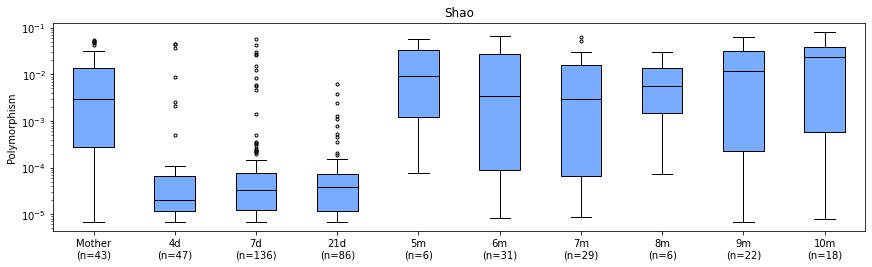

In [20]:
fig, ax = plt.subplots(figsize=(12, 3.6), sharey=True, constrained_layout=True)

# Shao
month_bins = np.arange(4, 15) * 30.5
order_bins = [0, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 21] + list(month_bins)

shao_samples = su.get_sample_names('Shao')
order_polymorphism_dict = defaultdict(list)
order_subjects_dict = defaultdict(set)

for sample in shao_samples:
    subject, order = sample_order_map[sample]
    if subject in order_subjects_dict[tp]: # Ensure one sample per subject for particular timepoint bin
        continue
    
    if desired_species in sample_species_polymorphism_dict[sample]:
        polymorphism = sample_species_polymorphism_dict[sample][desired_species]
    else:
        continue
    if subject[-1] == 'M': # Mother
        order_polymorphism_dict[0].append(polymorphism)
    elif order > 21: # Convert to month bins
        month_bin = round_down(order, 30.5)
        order_polymorphism_dict[month_bin].append(polymorphism)
    else:
        order_polymorphism_dict[order].append(polymorphism)
    
    order_subjects_dict[tp].add(subject)    

plot_data = [order_polymorphism_dict[o] for o in order_bins if len(order_polymorphism_dict[o]) > 5]
order_labels = ['Mother', '4d', '6d', '7d', '8d', '9d', '10d', '11d', '12d', '13d', '14d', '17d', '18d', '21d', '4m', '5m', '6m', '7m', '8m', '9m', '10m', '11m', '12m', '13m', '14m']
order_labels_with_n = [label + '\n(n=%i)' % len(order_polymorphism_dict[o]) for label, o in zip(order_labels, order_bins) if len(order_polymorphism_dict[o]) > 5]

ax.set_yscale('log')
boxplots = ax.boxplot(plot_data, patch_artist=True, 
                 boxprops=boxprops, 
                 medianprops=medianprops,
                 flierprops=flierprops)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

ax.set_xticklabels(order_labels_with_n)
ax.set_ylabel("Polymorphism")
ax.set_title("Shao")

In [8]:
# Now that Backhed has more granular timepoints, reevaluate distribution of cohorts by timepoint
days = sorted(list(set(mi_sample_day_dict.values())))
tp_cohort_sample_count_dict = {day: defaultdict(int) for day in days}
for sample in mi_sample_day_dict:
    if sample not in infant_samples:
        continue
    day = mi_sample_day_dict[sample]
    cohort = sample_cohort_map[sample]
    tp_cohort_sample_count_dict[day][cohort] += 1

for day in days:    
    if len(tp_cohort_sample_count_dict[day]) > 1 and sum(tp_cohort_sample_count_dict[day].values()) > 15:
        print("%i ======================================" % day)
        for cohort in tp_cohort_sample_count_dict[day]:
            print("\t%s: %i" % (cohort, tp_cohort_sample_count_dict[day][cohort]))

0 ======================================
	backhed: 3
	yassour: 42
1 ======================================
	backhed: 12
	ferretti: 20
3 ======================================
	backhed: 22
	ferretti: 23
4 ======================================
	backhed: 10
	shao: 310
7 ======================================
	backhed: 5
	ferretti: 23
	shao: 532
14 ======================================
	yassour: 32
	shao: 5
30 ======================================
	ferretti: 18
	yassour: 32
122 ======================================
	backhed: 10
	ferretti: 14


Effect size: 0.04920313624760915
p: 0.8174832600706254
Effect size: 0.037100851517673894
p: 0.5864378459438
Effect size: 0.03805250976623855
p: 0.5751053870732747
Effect size: 0.1594370348044234
p: 0.4074105288916988
Effect size: 0.026579941793468977
p: 0.7343460954617602
Effect size: 0.11846645208302714
p: 0.13896787384073628
Effect size: 0.15930232260419827
p: 0.15945110675468233
Effect size: 0.1854265552412815
p: 0.11562703798141792


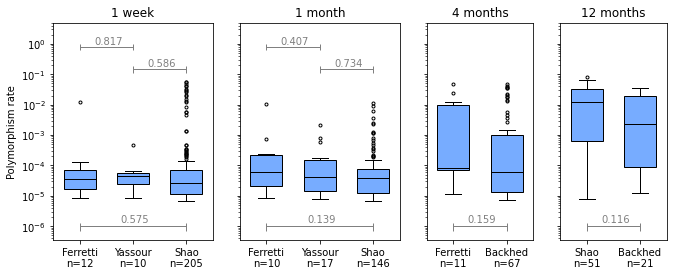

In [8]:
# Compare datasets

desired_species = 'Escherichia_coli_58110'

cohorts = ['hmp', 'backhed', 'ferretti', 'yassour', 'shao']
cohort_tp_polymorphism_dict = {cohort: defaultdict(list) for cohort in cohorts}

for sample in sample_cohort_map:
    tp = su.sample_to_tp(sample, sample_order_map, hmp_samples, mother_samples_orig)
    if sample_cohort_map[sample] == 'backhed' and mi_sample_day_dict[sample] == 7:
        tp = '7d'
    cohort = sample_cohort_map[sample]
    if cohort == 'shao':
        subject, order = sample_order_map[sample]
        if subject[-1] == 'M': # Mother
            tp = 0
        elif order > 21: # Convert to month bins
            tp = round_down(order, 30.5)
        else:
            tp = order
    if cohort not in cohorts:
        continue
    
    if desired_species in sample_species_polymorphism_dict[sample]:
        cohort_tp_polymorphism_dict[cohort][tp].append(sample_species_polymorphism_dict[sample][desired_species])

fig, ax = plt.subplots(1, 4, figsize=(11, 4), 
                       sharey=True,
                       gridspec_kw={'width_ratios': [3, 3, 2, 2]})

# 1 week (Ferretti / Yassour / Shao / Backhed)
cohort_tp_tups = [('ferretti', 'I3'), ('yassour', 'I2'), ('shao',7)]# , ('backhed', '7d')]
plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]

ax[0].set_yscale('log')
boxplots = ax[0].boxplot(plot_data, patch_artist=True, 
                 boxprops=dict(color='black'), 
                 medianprops=dict(color='black'),
                 flierprops=dict(marker='.'), widths=0.6)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j, tick in zip([(0, 1), (1, 2), (0, 2)], [0.8, 0.15, 1e-6], [0.18, 0.036, 3e-7]):
    i1, i2 = itup
    U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
    print("Effect size: %s" % (MWU_effect_size(p, len(plot_data[i1]), len(plot_data[i2]))))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[0], j, i1+1, i2+1, color=color, tickh=tick)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[0].text(i1+1+((i2-i1)/2)-offset, j+tick, label, color=color)

ax[0].set_title('1 week')
ax[0].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(cohort_tp_polymorphism_dict[cohort][tp])) \
                       for (cohort, tp) in cohort_tp_tups])
ax[0].set_ylabel('Polymorphism rate')
'''
# 2 weeks
cohort_tp_tups = [('yassour', 'I3'), ('shao',14)]
plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]

ax[1].set_yscale('log')
boxplots = ax[1].boxplot(plot_data, patch_artist=True, 
                 boxprops=dict(color='black'), 
                 medianprops=dict(color='black'),
                 flierprops=dict(marker='.'), widths=0.6)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j, tick in zip([(0, 1)], [1e-6], [3e-7]):
    i1, i2 = itup
    U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
    print("Effect size: %s" % (MWU_effect_size(p, len(plot_data[i1]), len(plot_data[i2]))))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[1], j, i1+1, i2+1, color=color, tickh=tick)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[1].text(i1+1+((i2-i1)/2)-offset, j+tick, label, color=color)

ax[1].set_title('2 weeks')
ax[1].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(cohort_tp_polymorphism_dict[cohort][tp])) \
                       for (cohort, tp) in cohort_tp_tups])
'''
# 1 month
cohort_tp_tups = [('ferretti', 'I4'), ('yassour', 'I4'), ('shao',21)]
plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]

ax[1].set_yscale('log')
boxplots = ax[1].boxplot(plot_data, patch_artist=True, widths=0.6, boxprops=dict(color='black'), medianprops=dict(color='black'), flierprops=dict(marker='.'))
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j, tick in zip([(0, 1), (1, 2), (0, 2)], [0.8, 0.15, 1e-6], [0.18, 0.036, 3e-7]):
    i1, i2 = itup
    U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
    print("Effect size: %s" % (MWU_effect_size(p, len(plot_data[i1]), len(plot_data[i2]))))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[1], j, i1+1, i2+1, color=color, tickh=tick)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[1].text(i1+1+((i2-i1)/2)-offset, j+tick, label, color=color)

ax[1].set_title('1 month')
ax[1].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(cohort_tp_polymorphism_dict[cohort][tp])) \
                       for (cohort, tp) in cohort_tp_tups])

# 4 months
cohort_tp_tups = [('ferretti', 'I5'), ('backhed', 'I2')]
plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]

ax[2].set_yscale('log')
boxplots = ax[2].boxplot(plot_data, patch_artist=True, 
                 boxprops=dict(color='black'), 
                 medianprops=dict(color='black'),
                 flierprops=dict(marker='.'), widths=0.6)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j in zip([(0, 1)], [1e-6]):
    i1, i2 = itup
    U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
    print("Effect size: %s" % (MWU_effect_size(p, len(plot_data[i1]), len(plot_data[i2]))))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[2], j, i1+1, i2+1, color=color, tickh=3e-7)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[2].text(i1+1+((i2-i1)/2)-offset, j+3e-7, label, color=color)

ax[2].set_title('4 months')
ax[2].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(cohort_tp_polymorphism_dict[cohort][tp])) \
                       for (cohort, tp) in cohort_tp_tups])

# 12 months
a = []
for tp in cohort_tp_polymorphism_dict['shao']:
    if tp > 300:
        a += cohort_tp_polymorphism_dict['shao'][tp]
b = cohort_tp_polymorphism_dict['backhed']['I3']
plot_data = [a, b]

ax[3].set_yscale('log')
boxplots = ax[3].boxplot(plot_data, patch_artist=True, 
                 boxprops=dict(color='black'), 
                 medianprops=dict(color='black'),
                 flierprops=dict(marker='.'), widths=0.6)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j in zip([(0, 1)], [1e-6]):
    i1, i2 = itup
    U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
    print("Effect size: %s" % (MWU_effect_size(p, len(plot_data[i1]), len(plot_data[i2]))))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[3], j, i1+1, i2+1, color=color, tickh=3e-7)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[3].text(i1+1+((i2-i1)/2)-offset, j+3e-7, label, color=color)

ax[3].set_title('12 months')
ax[3].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(vals)) \
                       for (cohort, vals) in zip(['shao', 'backhed'], [a, b])])
ax[0].set_ylim(top=5)

fig.savefig('%s/polymorphism_compare_cohort_matched_tp.pdf' % (config.analysis_directory), bbox_inches='tight')

In [10]:
# 1 week (Ferretti / Yassour / Shao / Backhed) - do Backhed comparisons
cohort_tp_tups = [('ferretti', 'I3'), ('yassour', 'I2'), ('shao',7), ('backhed', '7d')]
plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]

for i1, i2 in [(0, 3), (1, 3), (2, 3)]:
    U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
    print("Effect size: %s" % (MWU_effect_size(p, len(plot_data[i1]), len(plot_data[i2]))))
    print("p: %s" % str(p))

Effect size: 0.16049771371529212
p: 0.5208791208791208
Effect size: 0.23778263563887153
p: 0.3736263736263737
Effect size: 0.04887716662226995
p: 0.4798094938616145


Effect size: 0.12592471753807263
p: 0.6904761904761905
Effect size: 0.0
p: 1.0
Effect size: 0.06867782183596573
p: 0.7972027972027972
Effect size: 0.4728850662428856
p: 0.030232443854734878
Effect size: 0.002369003686498532
p: 0.9799091126524757


[Text(1, 0, 'Shao\nn=110'), Text(2, 0, 'Backhed\nn=3')]

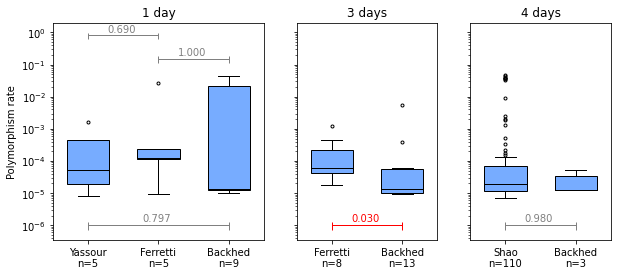

In [21]:
# Compare datasets

desired_species = 'Escherichia_coli_58110'

cohorts = ['hmp', 'backhed', 'ferretti', 'yassour', 'shao']
cohort_tp_polymorphism_dict = {cohort: defaultdict(list) for cohort in cohorts} # Now tp is a day (for infants only)

for sample in sample_cohort_map:
    if sample not in infant_samples:
        continue
    day = mi_sample_day_dict[sample]
    cohort = sample_cohort_map[sample]
    if desired_species in sample_species_polymorphism_dict[sample]:
        cohort_tp_polymorphism_dict[cohort][day].append(sample_species_polymorphism_dict[sample][desired_species])

fig, ax = plt.subplots(1, 3, figsize=(10, 4), 
                       sharey=True,
                       gridspec_kw={'width_ratios': [3, 2, 2]})

# 1 day (Ferretti / Backhed) also throw in Yassour birth for good measure
cohort_tp_tups = [('yassour', 0), ('ferretti', 1), ('backhed', 1)]
plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]

ax[0].set_yscale('log')
boxplots = ax[0].boxplot(plot_data, patch_artist=True, boxprops=boxprops, medianprops=medianprops, flierprops=flierprops, widths=0.6)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j, tick in zip([(0, 1), (1, 2), (0, 2)], [0.8, 0.15, 1e-6], [0.18, 0.036, 3e-7]):
    i1, i2 = itup
    U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
    print("Effect size: %s" % (MWU_effect_size(p, len(plot_data[i1]), len(plot_data[i2]))))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[0], j, i1+1, i2+1, color=color, tickh=tick)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[0].text(i1+1+((i2-i1)/2)-offset, j+tick, label, color=color)

ax[0].set_title('1 day')
ax[0].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(cohort_tp_polymorphism_dict[cohort][tp])) \
                       for (cohort, tp) in cohort_tp_tups])
ax[0].set_ylabel('Polymorphism rate')

# 3 days (Ferretti / Backhed)
cohort_tp_tups = [('ferretti', 3), ('backhed', 3)]
plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]

ax[1].set_yscale('log')
boxplots = ax[1].boxplot(plot_data, patch_artist=True, 
                 boxprops=dict(color='black'), 
                 medianprops=dict(color='black'),
                 flierprops=dict(marker='.'), widths=0.6)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j, tick in zip([(0, 1)], [1e-6], [3e-7]):
    i1, i2 = itup
    U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
    print("Effect size: %s" % (MWU_effect_size(p, len(plot_data[i1]), len(plot_data[i2]))))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[1], j, i1+1, i2+1, color=color, tickh=tick)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[1].text(i1+1+((i2-i1)/2)-offset, j+tick, label, color=color)

ax[1].set_title('3 days')
ax[1].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(cohort_tp_polymorphism_dict[cohort][tp])) \
                       for (cohort, tp) in cohort_tp_tups])

# 4 days (Backhed / Yassour)
cohort_tp_tups = [('shao', 4), ('backhed', 4)]
plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]

ax[2].set_yscale('log')
boxplots = ax[2].boxplot(plot_data, patch_artist=True, 
                 boxprops=dict(color='black'), 
                 medianprops=dict(color='black'),
                 flierprops=dict(marker='.'), widths=0.6)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j, tick in zip([(0, 1)], [1e-6], [3e-7]):
    i1, i2 = itup
    U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
    print("Effect size: %s" % (MWU_effect_size(p, len(plot_data[i1]), len(plot_data[i2]))))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[2], j, i1+1, i2+1, color=color, tickh=tick)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[2].text(i1+1+((i2-i1)/2)-offset, j+tick, label, color=color)

ax[2].set_title('4 days')
ax[2].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(cohort_tp_polymorphism_dict[cohort][tp])) \
                       for (cohort, tp) in cohort_tp_tups])

Effect size: 0.12592471753807263
p: 0.6904761904761905
Effect size: 0.0864865928885138
p: 0.7213962508080154
Effect size: 0.0
p: 1.0
Effect size: 0.4728850662428856
p: 0.030232443854734878
Effect size: 0.002369003686498532
p: 0.9799091126524757
Effect size: 0.04920313624760915
p: 0.8174832600706254
Effect size: 0.037100851517673894
p: 0.5864378459438
Effect size: 0.03805250976623855
p: 0.5751053870732747
Effect size: 0.1594370348044234
p: 0.4074105288916988
Effect size: 0.026579941793468977
p: 0.7343460954617602
Effect size: 0.11846645208302714
p: 0.13896787384073628
Effect size: 0.15930232260419827
p: 0.15945110675468233
Effect size: 0.1854265552412815
p: 0.11562703798141792


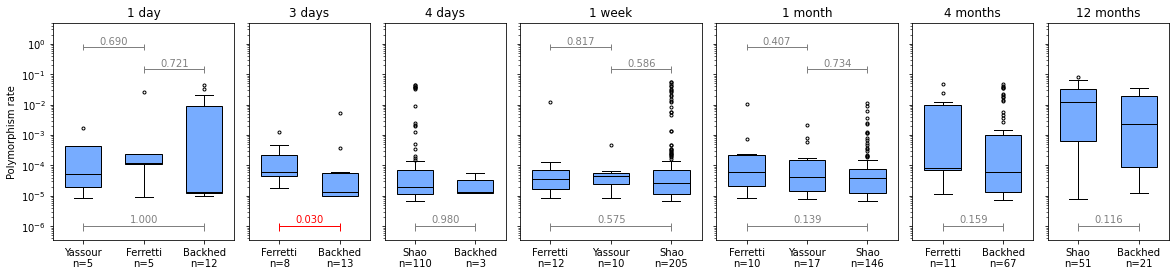

In [14]:
# Combine matched timepoint polymorphism rate comparion

# Compare datasets

desired_species = 'Escherichia_coli_58110'

cohorts = ['hmp', 'backhed', 'ferretti', 'yassour', 'shao']
cohort_tp_polymorphism_dict = {cohort: defaultdict(list) for cohort in cohorts} # Now tp is a day (for infants only)

for sample in sample_cohort_map:
    if sample not in infant_samples:
        continue
    day = mi_sample_day_dict[sample]
    cohort = sample_cohort_map[sample]
    if desired_species in sample_species_polymorphism_dict[sample]:
        cohort_tp_polymorphism_dict[cohort][day].append(sample_species_polymorphism_dict[sample][desired_species])

fig, ax = plt.subplots(1, 7, figsize=(20, 4), 
                       sharey=True,
                       gridspec_kw={'width_ratios': [3, 2, 2, 3, 3, 2, 2]})

# 1 day (Ferretti / Backhed) also throw in Yassour birth for good measure
i = 0
cohort_tp_tups = [('yassour', 0), ('ferretti', 1), ('backhed', 1)]
plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
plot_data[2] += cohort_tp_polymorphism_dict['backhed'][0] # Backhed actually both 0 and 1 days

ax[i].set_yscale('log')
boxplots = ax[i].boxplot(plot_data, patch_artist=True, boxprops=boxprops, medianprops=medianprops, flierprops=flierprops, widths=0.6)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j, tick in zip([(0, 1), (1, 2), (0, 2)], [0.8, 0.15, 1e-6], [0.18, 0.036, 3e-7]):
    i1, i2 = itup
    U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
    print("Effect size: %s" % (MWU_effect_size(p, len(plot_data[i1]), len(plot_data[i2]))))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[i], j, i1+1, i2+1, color=color, tickh=tick)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[i].text(i1+1+((i2-i1)/2)-offset, j+tick, label, color=color)

ax[i].set_title('1 day')
ax[i].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(cohort_tp_polymorphism_dict[cohort][tp])) \
                       for (cohort, tp) in cohort_tp_tups])
ax[i].set_ylabel('Polymorphism rate')

# 3 days (Ferretti / Backhed)
i += 1
cohort_tp_tups = [('ferretti', 3), ('backhed', 3)]
plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]

ax[i].set_yscale('log')
boxplots = ax[i].boxplot(plot_data, patch_artist=True, 
                 boxprops=dict(color='black'), 
                 medianprops=dict(color='black'),
                 flierprops=dict(marker='.'), widths=0.6)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j, tick in zip([(0, 1)], [1e-6], [3e-7]):
    i1, i2 = itup
    U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
    print("Effect size: %s" % (MWU_effect_size(p, len(plot_data[i1]), len(plot_data[i2]))))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[i], j, i1+1, i2+1, color=color, tickh=tick)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[i].text(i1+1+((i2-i1)/2)-offset, j+tick, label, color=color)

ax[i].set_title('3 days')
ax[i].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(cohort_tp_polymorphism_dict[cohort][tp])) \
                       for (cohort, tp) in cohort_tp_tups])

# 4 days (Backhed / Yassour)
i += 1
cohort_tp_tups = [('shao', 4), ('backhed', 4)]
plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]

ax[i].set_yscale('log')
boxplots = ax[i].boxplot(plot_data, patch_artist=True, 
                 boxprops=dict(color='black'), 
                 medianprops=dict(color='black'),
                 flierprops=dict(marker='.'), widths=0.6)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j, tick in zip([(0, 1)], [1e-6], [3e-7]):
    i1, i2 = itup
    U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
    print("Effect size: %s" % (MWU_effect_size(p, len(plot_data[i1]), len(plot_data[i2]))))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[i], j, i1+1, i2+1, color=color, tickh=tick)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[i].text(i1+1+((i2-i1)/2)-offset, j+tick, label, color=color)

ax[i].set_title('4 days')
ax[i].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(cohort_tp_polymorphism_dict[cohort][tp])) \
                       for (cohort, tp) in cohort_tp_tups])

# Later timepoints
cohort_tp_polymorphism_dict = {cohort: defaultdict(list) for cohort in cohorts}

for sample in sample_cohort_map:
    tp = su.sample_to_tp(sample, sample_order_map, hmp_samples, mother_samples_orig)
    if sample_cohort_map[sample] == 'backhed' and mi_sample_day_dict[sample] == 7:
        tp = '7d'
    cohort = sample_cohort_map[sample]
    if cohort == 'shao':
        subject, order = sample_order_map[sample]
        if subject[-1] == 'M': # Mother
            tp = 0
        elif order > 21: # Convert to month bins
            tp = round_down(order, 30.5)
        else:
            tp = order
    if cohort not in cohorts:
        continue
    
    if desired_species in sample_species_polymorphism_dict[sample]:
        cohort_tp_polymorphism_dict[cohort][tp].append(sample_species_polymorphism_dict[sample][desired_species])

# 1 week (Ferretti / Yassour / Shao / Backhed)
i += 1
cohort_tp_tups = [('ferretti', 'I3'), ('yassour', 'I2'), ('shao',7)]# , ('backhed', '7d')]
plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]

ax[i].set_yscale('log')
boxplots = ax[i].boxplot(plot_data, patch_artist=True, 
                 boxprops=dict(color='black'), 
                 medianprops=dict(color='black'),
                 flierprops=dict(marker='.'), widths=0.6)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j, tick in zip([(0, 1), (1, 2), (0, 2)], [0.8, 0.15, 1e-6], [0.18, 0.036, 3e-7]):
    i1, i2 = itup
    U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
    print("Effect size: %s" % (MWU_effect_size(p, len(plot_data[i1]), len(plot_data[i2]))))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[i], j, i1+1, i2+1, color=color, tickh=tick)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[i].text(i1+1+((i2-i1)/2)-offset, j+tick, label, color=color)

ax[i].set_title('1 week')
ax[i].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(cohort_tp_polymorphism_dict[cohort][tp])) \
                       for (cohort, tp) in cohort_tp_tups])

# 1 month
i += 1
cohort_tp_tups = [('ferretti', 'I4'), ('yassour', 'I4'), ('shao',21)]
plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]

ax[i].set_yscale('log')
boxplots = ax[i].boxplot(plot_data, patch_artist=True, widths=0.6, boxprops=dict(color='black'), medianprops=dict(color='black'), flierprops=dict(marker='.'))
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j, tick in zip([(0, 1), (1, 2), (0, 2)], [0.8, 0.15, 1e-6], [0.18, 0.036, 3e-7]):
    i1, i2 = itup
    U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
    print("Effect size: %s" % (MWU_effect_size(p, len(plot_data[i1]), len(plot_data[i2]))))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[i], j, i1+1, i2+1, color=color, tickh=tick)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[i].text(i1+1+((i2-i1)/2)-offset, j+tick, label, color=color)

ax[i].set_title('1 month')
ax[i].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(cohort_tp_polymorphism_dict[cohort][tp])) \
                       for (cohort, tp) in cohort_tp_tups])

# 4 months
i += 1
cohort_tp_tups = [('ferretti', 'I5'), ('backhed', 'I2')]
plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]

ax[i].set_yscale('log')
boxplots = ax[i].boxplot(plot_data, patch_artist=True, 
                 boxprops=dict(color='black'), 
                 medianprops=dict(color='black'),
                 flierprops=dict(marker='.'), widths=0.6)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j in zip([(0, 1)], [1e-6]):
    i1, i2 = itup
    U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
    print("Effect size: %s" % (MWU_effect_size(p, len(plot_data[i1]), len(plot_data[i2]))))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[i], j, i1+1, i2+1, color=color, tickh=3e-7)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[i].text(i1+1+((i2-i1)/2)-offset, j+3e-7, label, color=color)

ax[i].set_title('4 months')
ax[i].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(cohort_tp_polymorphism_dict[cohort][tp])) \
                       for (cohort, tp) in cohort_tp_tups])

# 12 months
i += 1
a = []
for tp in cohort_tp_polymorphism_dict['shao']:
    if tp > 300:
        a += cohort_tp_polymorphism_dict['shao'][tp]
b = cohort_tp_polymorphism_dict['backhed']['I3']
plot_data = [a, b]

ax[i].set_yscale('log')
boxplots = ax[i].boxplot(plot_data, patch_artist=True, 
                 boxprops=dict(color='black'), 
                 medianprops=dict(color='black'),
                 flierprops=dict(marker='.'), widths=0.6)
for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')

for itup, j in zip([(0, 1)], [1e-6]):
    i1, i2 = itup
    U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
    print("Effect size: %s" % (MWU_effect_size(p, len(plot_data[i1]), len(plot_data[i2]))))
    print("p: %s" % str(p))
    color = 'red' if p < 0.05 else 'gray'
    plot_interval_on_ax(ax[i], j, i1+1, i2+1, color=color, tickh=3e-7)
    label = '{:.2e}'.format(p) if p < 0.01 else ('%.03f' % p)
    offset = 0.36 if p < 0.01 else 0.23
    ax[i].text(i1+1+((i2-i1)/2)-offset, j+3e-7, label, color=color)

ax[i].set_title('12 months')
ax[i].set_xticklabels(['%s\nn=%i' % (cohort.capitalize(), len(vals)) \
                       for (cohort, vals) in zip(['shao', 'backhed'], [a, b])])
ax[i].set_ylim(top=5)

plt.subplots_adjust(wspace=0.1)

fig.savefig('%s/polymorphism_compare_cohort_matched_tp_v2.pdf' % (config.analysis_directory), bbox_inches='tight')

In [21]:
# Now report statistics for all species
# Compare datasets
# Also store results in a table

f = open('%s/matched_timepoint_polymorphism_dataset_sig_tests.csv' % config.analysis_directory, 'w')
f.write(','.join(['species', 'timepoint', 'cohort1', 'n1', 'cohort2', 'n2', 'U', 'p']) + '\n')

cohorts = ['hmp', 'backhed', 'ferretti', 'yassour', 'shao']

min_sample_size = 10

total_total_number_tests = 0
total_total_sig_tests = 0

orig_p = 0.05
correction_factor = 18

for desired_species in good_species_list[:13]:
    print("============================================================")
    print(desired_species)
    print("============================================================")
    
    total_number_tests = 0
    total_sig_tests = 0
    
    cohort_tp_polymorphism_dict = {cohort: defaultdict(list) for cohort in cohorts} # Now tp is a day (for infants only)
    for sample in sample_cohort_map:
        if sample not in infant_samples:
            continue
        day = mi_sample_day_dict[sample]
        cohort = sample_cohort_map[sample]
        if desired_species in sample_species_polymorphism_dict[sample]:
            cohort_tp_polymorphism_dict[cohort][day].append(sample_species_polymorphism_dict[sample][desired_species])
    
    # 1 day (Ferretti / Backhed)
    cohort_tp_tups = [('ferretti', 1), ('backhed', 1)]
    plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
    for i1, i2 in [(0, 1)]:
        if len(plot_data[i1]) >= min_sample_size and len(plot_data[i2]) >= min_sample_size:
            U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
            total_number_tests += 1
            if p < (orig_p/correction_factor):
                total_sig_tests += 1
                print("1 day/birth: %s vs. %s: p=%s" % (str(cohort_tp_tups[i1][0]), str(cohort_tp_tups[i2][0]), str(p)))
        else:
            U = 'NA'; p = 'NA'
        f.write(','.join([str(x) for x in [desired_species, '1 day', cohort_tp_tups[i1][0], len(plot_data[i1]), 
                                           cohort_tp_tups[i2][0], len(plot_data[i2]), U, p]]) + '\n')
    
    # 3 days (Ferretti / Backhed)
    cohort_tp_tups = [('ferretti', 3), ('backhed', 3)]
    plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
    for i1, i2 in [(0, 1)]:
        if len(plot_data[i1]) >= min_sample_size and len(plot_data[i2]) >= min_sample_size:          
            U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
            total_number_tests += 1
            if p < (orig_p/correction_factor):
                total_sig_tests += 1
                print("3 days: %s vs. %s: p=%s" % (str(cohort_tp_tups[i1][0]), str(cohort_tp_tups[i2][0]), str(p)))
        else:
            U = 'NA'; p = 'NA'
        f.write(','.join([str(x) for x in [desired_species, '3 days', cohort_tp_tups[i1][0], len(plot_data[i1]), 
                                           cohort_tp_tups[i2][0], len(plot_data[i2]), U, p]]) + '\n')
    
    # 4 days (Backhed / Yassour)
    cohort_tp_tups = [('shao', 4), ('backhed', 4)]
    plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
    for i1, i2 in [(0, 1)]:
        if len(plot_data[i1]) >= min_sample_size and len(plot_data[i2]) >= min_sample_size:
            U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
            total_number_tests += 1
            if p < (orig_p/correction_factor):
                total_sig_tests += 1
                print("4 days: %s vs. %s: p=%s" % (str(cohort_tp_tups[i1][0]), str(cohort_tp_tups[i2][0]), str(p)))
        else:
            U = 'NA'; p = 'NA'
        f.write(','.join([str(x) for x in [desired_species, '4 days', cohort_tp_tups[i1][0], len(plot_data[i1]), 
                                           cohort_tp_tups[i2][0], len(plot_data[i2]), U, p]]) + '\n')
    
    # Reset
    cohort_tp_polymorphism_dict = {cohort: defaultdict(list) for cohort in cohorts}
    
    for sample in sample_cohort_map:
        tp = su.sample_to_tp(sample, sample_order_map, hmp_samples, mother_samples_orig)
        if sample_cohort_map[sample] == 'backhed' and mi_sample_day_dict[sample] == 7:
            tp = '7d'
        cohort = sample_cohort_map[sample]
        if cohort == 'shao':
            subject, order = sample_order_map[sample]
            if subject[-1] == 'M': # Mother
                tp = 0
            elif order > 21: # Convert to month bins
                tp = round_down(order, 30.5)
            else:
                tp = order
        if cohort not in cohorts:
            continue
        
        if desired_species in sample_species_polymorphism_dict[sample]:
            cohort_tp_polymorphism_dict[cohort][tp].append(sample_species_polymorphism_dict[sample][desired_species])
    
    # 1 week (Ferretti / Yassour / Shao)
    cohort_tp_tups = [('ferretti', 'I3'), ('yassour', 'I2'), ('shao',7)]
    plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
    for i1, i2 in [(0, 1), (1, 2), (0, 2)]:
        if len(plot_data[i1]) >= min_sample_size and len(plot_data[i2]) >= min_sample_size:
            U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
            total_number_tests += 1
            if p < (orig_p/correction_factor):
                total_sig_tests += 1
                print("1 week: %s vs. %s: p=%s" % (str(cohort_tp_tups[i1][0]), str(cohort_tp_tups[i2][0]), str(p)))
        else:
            U = 'NA'; p = 'NA'
        f.write(','.join([str(x) for x in [desired_species, '1 week', cohort_tp_tups[i1][0], len(plot_data[i1]), 
                                           cohort_tp_tups[i2][0], len(plot_data[i2]), U, p]]) + '\n')
    
    # 2 weeks
    cohort_tp_tups = [('yassour', 'I3'), ('shao',14)]
    plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
    for i1, i2 in [(0, 1)]:
        if len(plot_data[i1]) >= min_sample_size and len(plot_data[i2]) >= min_sample_size:
            U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
            total_number_tests += 1
            if p < (orig_p/correction_factor):
                total_sig_tests += 1
                print("2 weeks: %s vs. %s: p=%s" % (str(cohort_tp_tups[i1][0]), str(cohort_tp_tups[i2][0]), str(p)))
        else:
            U = 'NA'; p = 'NA'
        f.write(','.join([str(x) for x in [desired_species, '2 weeks', cohort_tp_tups[i1][0], len(plot_data[i1]), 
                                           cohort_tp_tups[i2][0], len(plot_data[i2]), U, p]]) + '\n')
    
    # 1 month
    cohort_tp_tups = [('ferretti', 'I4'), ('yassour', 'I4'), ('shao',21)]
    plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
    for i1, i2 in [(0, 1), (1, 2), (0, 2)]:
        if len(plot_data[i1]) >= min_sample_size and len(plot_data[i2]) >= min_sample_size:      
            U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
            total_number_tests += 1
            if p < (orig_p/correction_factor):
                total_sig_tests += 1
                print("1 month: %s vs. %s: p=%s" % (str(cohort_tp_tups[i1][0]), str(cohort_tp_tups[i2][0]), str(p)))
        else:
            U = 'NA'; p = 'NA'
        f.write(','.join([str(x) for x in [desired_species, '1 month', cohort_tp_tups[i1][0], len(plot_data[i1]), 
                                           cohort_tp_tups[i2][0], len(plot_data[i2]), U, p]]) + '\n')
    
    # 4 months
    cohort_tp_tups = [('ferretti', 'I5'), ('backhed', 'I2')]
    plot_data = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
    for i1, i2 in [(0, 1)]:
        if len(plot_data[i1]) >= min_sample_size and len(plot_data[i2]) >= min_sample_size:
            U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
            total_number_tests += 1
            if p < (orig_p/correction_factor):
                total_sig_tests += 1
                print("4 months: %s vs. %s: p=%s" % (str(cohort_tp_tups[i1][0]), str(cohort_tp_tups[i2][0]), str(p)))
        else:
            U = 'NA'; p = 'NA'
        f.write(','.join([str(x) for x in [desired_species, '4 months', cohort_tp_tups[i1][0], len(plot_data[i1]), 
                                           cohort_tp_tups[i2][0], len(plot_data[i2]), U, p]]) + '\n')
    
    # 12 months
    a = []
    for tp in cohort_tp_polymorphism_dict['shao']:
        if tp > 300:
            a += cohort_tp_polymorphism_dict['shao'][tp]
    b = cohort_tp_polymorphism_dict['backhed']['I3']
    plot_data = [a, b]
    for i1, i2 in [(0, 1)]:
        if len(plot_data[i1]) >= min_sample_size and len(plot_data[i2]) >= min_sample_size:
            U, p = scipy.stats.mannwhitneyu(plot_data[i1], plot_data[i2])
            total_number_tests += 1
            if p < (orig_p/correction_factor):
                total_sig_tests += 1
                print("12 months: %s vs. %s: p=%s" % (str(cohort_tp_tups[i1][0]), str(cohort_tp_tups[i2][0]), str(p)))
        else:
            U = 'NA'; p = 'NA'
        f.write(','.join([str(x) for x in [desired_species, '12 months', cohort_tp_tups[i1][0], len(plot_data[i1]), 
                                           cohort_tp_tups[i2][0], len(plot_data[i2]), U, p]]) + '\n')
    
    print("**** %i/%i tests were significant" % (total_sig_tests, total_number_tests))
    total_total_number_tests += total_number_tests
    total_total_sig_tests += total_sig_tests

f.close()
print("GRAND TOTAL: %i/%i tests were significant" % (total_total_sig_tests, total_total_number_tests))

Escherichia_coli_58110
**** 0/12 tests were significant
Bacteroides_vulgatus_57955
**** 0/12 tests were significant
Enterococcus_faecalis_56297
**** 0/10 tests were significant
Bifidobacterium_longum_57796
**** 0/12 tests were significant
Bifidobacterium_breve_57133
**** 0/11 tests were significant
Klebsiella_pneumoniae_54788
**** 0/6 tests were significant
Staphylococcus_epidermidis_57523
**** 0/5 tests were significant
Bacteroides_uniformis_57318
**** 0/10 tests were significant
Bifidobacterium_bifidum_55065
12 months: ferretti vs. backhed: p=0.00017769814898103978
**** 1/10 tests were significant
Bacteroides_ovatus_58035
**** 0/10 tests were significant
Veillonella_parvula_57794
**** 0/7 tests were significant
Alistipes_putredinis_61533
**** 0/2 tests were significant
Bacteroides_fragilis_54507
**** 0/5 tests were significant
GRAND TOTAL: 1/112 tests were significant


In [ ]:
# Make a table with species, number of tests, number of significant tests, p-values (corrected)
# Write up about these tests

In [32]:
U, p1 = scipy.stats.mannwhitneyu(plot_data[0][:-2], plot_data[1])
W, p2 = scipy.stats.wilcoxon(plot_data[0][:-2], plot_data[1])
print("U: %s" % str(U))
print("p: %s" % str(p1))
print("W: %s" % str(W))
print("p: %s" % str(p2))

U: 46.0
p: 0.7913367801006604
W: 25.0
p: 0.845703125


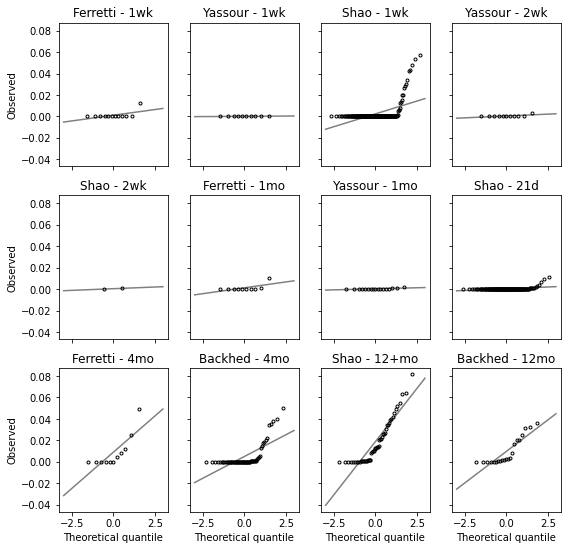

In [24]:
from scipy import stats

fig, ax = plt.subplots(3, 4, figsize=(9, 9),sharey=True, sharex=True)
xs = np.arange(-3, 3, 0.01)

# 1 week
cohort_tp_tups = [('ferretti', 'I3'), ('yassour', 'I2'), ('shao',7)]
x = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
vals = stats.probplot(x[0]); ax[0][0].set_title("Ferretti - 1wk")
osm, osr = vals[0]; m, b, r = vals[1]; ax[0][0].plot(xs, (m*xs)+b, color='gray'); ax[0][0].plot(osm, osr, '.', color='black', mfc='none')
vals = stats.probplot(x[1]); ax[0][1].set_title("Yassour - 1wk")
osm, osr = vals[0]; m, b, r = vals[1]; ax[0][1].plot(xs, (m*xs)+b, color='gray'); ax[0][1].plot(osm, osr, '.', color='black', mfc='none')
vals = stats.probplot(x[2]); ax[0][2].set_title("Shao - 1wk")
osm, osr = vals[0]; m, b, r = vals[1]; ax[0][2].plot(xs, (m*xs)+b, color='gray'); ax[0][2].plot(osm, osr, '.', color='black', mfc='none')

# 2 weeks
cohort_tp_tups = [('yassour', 'I3'), ('shao',14)]
x = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
vals = stats.probplot(x[0]); ax[0][3].set_title("Yassour - 2wk")
osm, osr = vals[0]; m, b, r = vals[1]; ax[0][3].plot(xs, (m*xs)+b, color='gray'); ax[0][3].plot(osm, osr, '.', color='black', mfc='none')
vals = stats.probplot(x[1]); ax[1][0].set_title("Shao - 2wk")
osm, osr = vals[0]; m, b, r = vals[1]; ax[1][0].plot(xs, (m*xs)+b, color='gray'); ax[1][0].plot(osm, osr, '.', color='black', mfc='none')

# 1 month
cohort_tp_tups = [('ferretti', 'I4'), ('yassour', 'I4'), ('shao',21)]
x = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
vals = stats.probplot(x[0]); ax[1][1].set_title("Ferretti - 1mo")
osm, osr = vals[0]; m, b, r = vals[1]; ax[1][1].plot(xs, (m*xs)+b, color='gray'); ax[1][1].plot(osm, osr, '.', color='black', mfc='none')
vals = stats.probplot(x[1]); ax[1][2].set_title("Yassour - 1mo")
osm, osr = vals[0]; m, b, r = vals[1]; ax[1][2].plot(xs, (m*xs)+b, color='gray'); ax[1][2].plot(osm, osr, '.', color='black', mfc='none')
vals = stats.probplot(x[2]); ax[1][3].set_title("Shao - 21d")
osm, osr = vals[0]; m, b, r = vals[1]; ax[1][3].plot(xs, (m*xs)+b, color='gray'); ax[1][3].plot(osm, osr, '.', color='black', mfc='none')

# 4 months
cohort_tp_tups = [('ferretti', 'I5'), ('backhed', 'I2')]
x = [cohort_tp_polymorphism_dict[cohort][tp] for (cohort, tp) in cohort_tp_tups]
vals = stats.probplot(x[0]); ax[2][0].set_title("Ferretti - 4mo")
osm, osr = vals[0]; m, b, r = vals[1]; ax[2][0].plot(xs, (m*xs)+b, color='gray'); ax[2][0].plot(osm, osr, '.', color='black', mfc='none')
vals = stats.probplot(x[1]); ax[2][1].set_title("Backhed - 4mo")
osm, osr = vals[0]; m, b, r = vals[1]; ax[2][1].plot(xs, (m*xs)+b, color='gray'); ax[2][1].plot(osm, osr, '.', color='black', mfc='none')

# 12 months
a = []
for tp in cohort_tp_polymorphism_dict['shao']:
    if tp > 300:
        a += cohort_tp_polymorphism_dict['shao'][tp]
b = cohort_tp_polymorphism_dict['backhed']['I3']
x = [a, b]
vals = stats.probplot(x[0]); ax[2][2].set_title("Shao - 12+mo")
osm, osr = vals[0]; m, b, r = vals[1]; ax[2][2].plot(xs, (m*xs)+b, color='gray'); ax[2][2].plot(osm, osr, '.', color='black', mfc='none')
vals = stats.probplot(x[1]); ax[2][3].set_title("Backhed - 12mo")
osm, osr = vals[0]; m, b, r = vals[1]; ax[2][3].plot(xs, (m*xs)+b, color='gray'); ax[2][3].plot(osm, osr, '.', color='black', mfc='none')

for i in range(3):
    ax[i][0].set_ylabel("Observed")

for i in range(4):
    ax[2][i].set_xlabel("Theoretical quantile")

In [62]:
# Store data for R Q-Q plots

# 1 week
cohort_tp_tups = [('ferretti', 'I3'), ('yassour', 'I2'), ('shao',7)]
for (cohort, tp) in cohort_tp_tups:
    polymorphisms = cohort_tp_polymorphism_dict[cohort][tp]
    with open('%s/polymorphisms_%s_%s.txt' % (config.analysis_directory, cohort, '1wk'), 'w') as f:
        f.write('\n'.join([str(p) for p in polymorphisms]))

# 2 weeks
cohort_tp_tups = [('yassour', 'I3'), ('shao',14)]
for (cohort, tp) in cohort_tp_tups:
    polymorphisms = cohort_tp_polymorphism_dict[cohort][tp]
    with open('%s/polymorphisms_%s_%s.txt' % (config.analysis_directory, cohort, '2wk'), 'w') as f:
        f.write('\n'.join([str(p) for p in polymorphisms]))

# 1 month
cohort_tp_tups = [('ferretti', 'I4'), ('yassour', 'I4'), ('shao',21)]
for (cohort, tp) in cohort_tp_tups:
    polymorphisms = cohort_tp_polymorphism_dict[cohort][tp]
    with open('%s/polymorphisms_%s_%s.txt' % (config.analysis_directory, cohort, '1mo'), 'w') as f:
        f.write('\n'.join([str(p) for p in polymorphisms]))

# 4 months
cohort_tp_tups = [('ferretti', 'I5'), ('backhed', 'I2')]
for (cohort, tp) in cohort_tp_tups:
    polymorphisms = cohort_tp_polymorphism_dict[cohort][tp]
    with open('%s/polymorphisms_%s_%s.txt' % (config.analysis_directory, cohort, '4mo'), 'w') as f:
        f.write('\n'.join([str(p) for p in polymorphisms]))

# 12 months
a = []
for tp in cohort_tp_polymorphism_dict['shao']:
    if tp > 300:
        a += cohort_tp_polymorphism_dict['shao'][tp]
b = cohort_tp_polymorphism_dict['backhed']['I3']
for cohort, polymorphisms in zip(['shao', 'backhed'], [a, b]):
    with open('%s/polymorphisms_%s_%s.txt' % (config.analysis_directory, cohort, '1yr'), 'w') as f:
        f.write('\n'.join([str(p) for p in polymorphisms]))

In [55]:
def flatten(list_of_lists):
    flattened_list = []
    for l in list_of_lists:
        flattened_list += l
    return flattened_list

In [61]:
# Compare before vs. after 4 months

desired_species = 'Escherichia_coli_58110'

cohorts = ['hmp', 'backhed', 'ferretti', 'yassour', 'shao']
cohort_tp_polymorphism_dict = {cohort: defaultdict(list) for cohort in cohorts}

for sample in sample_cohort_map:
    tp = su.sample_to_tp(sample, sample_order_map, hmp_samples, mother_samples_orig)
    cohort = sample_cohort_map[sample]
    if cohort == 'shao':
        subject, order = sample_order_map[sample]
        if subject[-1] == 'M': # Mother
            tp = 0
        elif order > 21: # Convert to month bins
            tp = round_down(order, 30.5)
        else:
            tp = order
    if cohort not in cohorts:
        continue
    
    if desired_species in sample_species_polymorphism_dict[sample]:
        cohort_tp_polymorphism_dict[cohort][tp].append(sample_species_polymorphism_dict[sample][desired_species])

backhed_pre4m = flatten([cohort_tp_polymorphism_dict['backhed'][tp] for tp in ['I1', 'I2']])
backhed_post4m = flatten([cohort_tp_polymorphism_dict['backhed'][tp] for tp in ['I3']])
summarize_ttest(backhed_pre4m, backhed_post4m, simple=False)

ferretti_pre4m = flatten([cohort_tp_polymorphism_dict['ferretti'][tp] for tp in ['I1', 'I2', 'I3', 'I4', 'I5']])
ferretti_post4m = flatten([cohort_tp_polymorphism_dict['ferretti'][tp] for tp in []])
summarize_ttest(ferretti_pre4m, ferretti_post4m, simple=False)

yassour_pre4m = flatten([cohort_tp_polymorphism_dict['yassour'][tp] for tp in ['I1', 'I2', 'I3', 'I4']])
yassour_post4m = flatten([cohort_tp_polymorphism_dict['yassour'][tp] for tp in []])
summarize_ttest(yassour_pre4m, yassour_post4m, simple=False)

shao_pre4m = flatten([cohort_tp_polymorphism_dict['shao'][tp] for tp in cohort_tp_polymorphism_dict['shao'] if tp <= 122])
shao_post4m = flatten([cohort_tp_polymorphism_dict['shao'][tp] for tp in cohort_tp_polymorphism_dict['shao'] if tp > 122])
summarize_ttest(shao_pre4m, shao_post4m, simple=False)

# Overall
summarize_ttest(backhed_pre4m + ferretti_pre4m + yassour_pre4m + shao_pre4m, backhed_post4m + shao_post4m, simple=False)

# fig.savefig('%s/polymorphism_compare_cohort_matched_tp.pdf' % (config.analysis_directory), bbox_inches='tight')

Group 1 size: 116 | Group 2 size: 21
T-statistic: -2.3361
P-value: 0.02095802665393092
Group 1 size: 46 | Group 2 size: 0
T-statistic: nan
P-value: nan
Group 1 size: 43 | Group 2 size: 0
T-statistic: nan
P-value: nan
Group 1 size: 523 | Group 2 size: 196
T-statistic: -12.7099
P-value: 1.5990135882162072e-33
Group 1 size: 728 | Group 2 size: 217
T-statistic: -13.8049
P-value: 1.2836751039484312e-39


# QP Stuff

In [7]:
# Grab QP samples for all species
cohorts = ['hmp', 'backhed', 'ferretti', 'yassour', 'shao']
samples = {cohort: su.get_sample_names(cohort) for cohort in cohorts}
sample_species_qp_dict = defaultdict(dict)

for species in good_species_list:
    for cohort in cohorts:
        qp_sample_sets = su.load_qp_samples(samples[cohort], species, prev_cohort='all')
        for qp_status in ['qp', 'non-qp', 'low-coverage']:
            for sample in qp_sample_sets[qp_status]:
                sample_species_qp_dict[sample][species] = qp_status

In [8]:
# These custom cohorts are for a single sample

custom_cohorts_ordered = ['Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Mother', 'HMP (Adult)']

def get_custom_cohort(cat, sample):
    if cat == 'infant':
        day = mi_sample_day_dict[sample]
        if day >= 0 and day <= 7:
            return 'Day 0-Week 1'
        elif day <= 32:
            return 'Week 1-Month 1'
        elif day <= 366:
            return 'Month 1-Year 1'
    elif cat == 'hmp':
        return 'HMP (Adult)'
    elif cat == 'mother':
        return 'Mother'

In [9]:
cat_sample_species_qp_dict = {cat: defaultdict(dict) for cat in ['mother', 'infant', 'hmp']}
for sample in sample_species_qp_dict:
    if sample in infant_samples:
        cat = 'infant'
    elif sample in mother_samples:
        cat = 'mother'
    elif sample in hmp_samples:
        cat = 'hmp'
    else:
        pass # Should only be Yassour +/- 3 months
    for species in sample_species_qp_dict[sample]:
        cat_sample_species_qp_dict[cat][sample][species] = sample_species_qp_dict[sample][species]

sample_num_qp_dict = {cat: defaultdict(int) for cat in ['mother', 'infant', 'hmp']}
sample_num_non_dict = {cat: defaultdict(int) for cat in ['mother', 'infant', 'hmp']}
sample_num_lowcov_dict = {cat: defaultdict(int) for cat in ['mother', 'infant', 'hmp']}

for cat in ['mother', 'infant', 'hmp']:
    for sample in cat_sample_species_qp_dict[cat]:
        for species in cat_sample_species_qp_dict[cat][sample]:
            qp_status = cat_sample_species_qp_dict[cat][sample][species]
            if qp_status == 'qp':
                sample_num_qp_dict[cat][sample] += 1
            elif qp_status == 'non-qp':
                sample_num_non_dict[cat][sample] += 1
            elif qp_status == 'low-coverage':
                sample_num_lowcov_dict[cat][sample] += 1


props_qp_by_dataset_by_cohort = {}
datasets = ['backhed', 'ferretti', 'yassour', 'shao', 'hmp']
dataset_samples = {dataset: su.get_sample_names(dataset) for dataset in datasets}

for dataset in datasets:
    props_qp_by_cohort = defaultdict(list)
    for cat in sample_num_qp_dict:
        for sample in sample_num_qp_dict[cat]:

            if sample not in dataset_samples[dataset]: # Restrict to individual dataset
                continue

            custom_cohort = get_custom_cohort(cat, sample)

            # Make sure we're only including mother at delivery
            if custom_cohort == 'Mother' and (mi_sample_day_dict[sample] < -1 or mi_sample_day_dict[sample] > 30):
                    continue

            num_qp = (sample_num_qp_dict[cat][sample])
            num_non = (sample_num_non_dict[cat][sample])
            num_lowcov = (sample_num_lowcov_dict[cat][sample])
            prop_qp = num_qp/float(num_qp+num_non)

            props_qp_by_cohort[custom_cohort].append(prop_qp)
    
    props_qp_by_dataset_by_cohort[dataset] = props_qp_by_cohort

In [44]:
# Analyze relationship between QP status and read count

# For each sample species pair, report: QP status, read count, host, dataset
output_file = open('%s/sample_qp_read_count.csv' % config.analysis_directory, 'w')
output_file.write(','.join(['species', 'sample', 'subject', 'qp_status', 'read_count', 'cohort']) + '\n')
sample_read_count_map = su.parse_sample_read_count_map()

for cohort in cohorts:
    for sample in samples[cohort]:
        subject = sample_subject_map[sample]
        read_count = sample_read_count_map[sample]
        for species in good_species_list:
            qp_status = sample_species_qp_dict[sample][species]
            output_file.write(','.join([species, sample, subject, qp_status, str(read_count), cohort]) + '\n')

output_file.close()

/tmp/ipykernel_6744/374654466.py:54: RuntimeWarning: invalid value encountered in true_divide
  ax[i][j].step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=cohort, where='pre',zorder=4)
/tmp/ipykernel_6744/374654466.py:54: RuntimeWarning: invalid value encountered in true_divide
  ax[i][j].step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=cohort, where='pre',zorder=4)
/tmp/ipykernel_6744/374654466.py:54: RuntimeWarning: invalid value encountered in true_divide
  ax[i][j].step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=cohort, where='pre',zorder=4)
/tmp/ipykernel_6744/374654466.py:54: RuntimeWarning: invalid value encountered in true_divide
  ax[i][j].step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=cohort, where='pre',zorder=4)


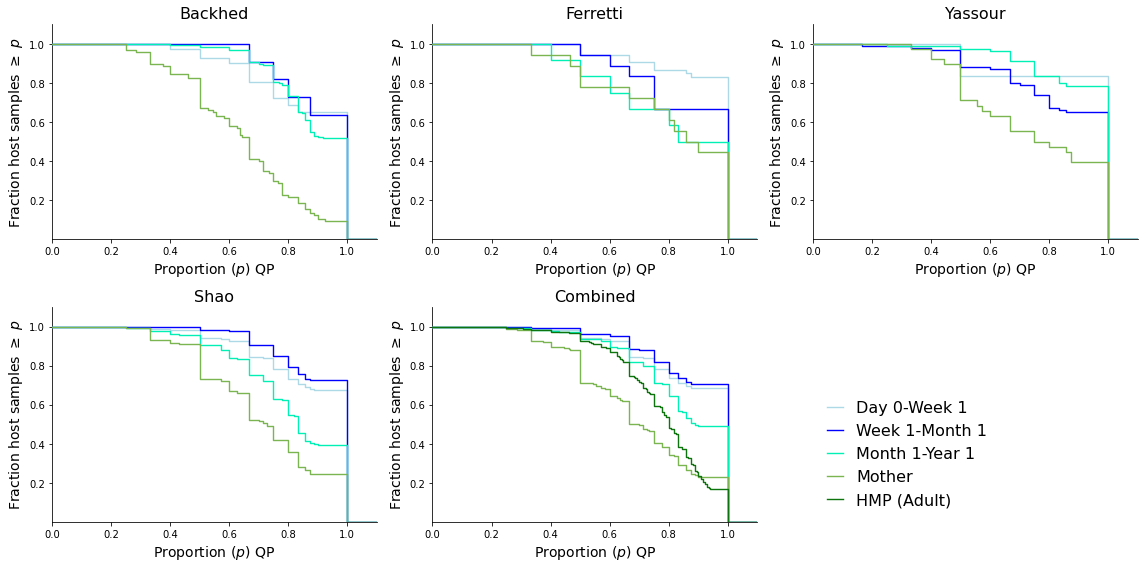

In [10]:
import matplotlib.cm as cmx

def calculate_unnormalized_survival_from_vector(counts):
    counts = sorted(counts)
    xs = [0]
    ns = [len(counts)]
    ns_cur = len(counts)
    min_count = -1
    for count in counts:
        if count > min_count:
            ns.append(ns_cur) # Number of elements greater or equal
            xs.append(count)
            min_count = count
        ns_cur -= 1
    xs.append(xs[len(xs)-1]+1)
    ns.append(0)
    return xs, np.array(ns)

fig, ax = plt.subplots(2, 3, figsize=(16,8))

colormap = cmx.get_cmap('viridis', 8)
colors = [colormap(x) for x in np.array([x for x in range(0,8)])/8.0]
colors = ['lightblue', 'blue', '#00f0b6', '#7bb551', '#0e750e']

modification_difference_threshold = config.modification_difference_threshold
replacement_difference_threshold = config.replacement_difference_threshold

# ax_snp.set_xscale('log')
# ax_snp.set_yscale('log')
dataset_idx = 0
for i in range(2):
    for j in range(3):
        if i == 1 and j >= 1:
            continue
        dataset = datasets[dataset_idx]
        ax[i][j].set_title(dataset.capitalize(), fontsize=16)
        
        ax[i][j].set_ylabel(r'Fraction host samples $\geq$ $p$', fontsize=14)
        ax[i][j].set_xlabel(r'Proportion ($p$) QP', fontsize=14)

        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].spines['right'].set_visible(False)
        ax[i][j].get_xaxis().tick_bottom()
        ax[i][j].get_yaxis().tick_left()

        color_i = 0

        ymin, ymax = 0.0001, 1.1
        ax[i][j].set_ylim([ymin,ymax])
        ax[i][j].set_xlim([0, 1.1])

        for cohort in custom_cohorts_ordered:
            xs, ns = calculate_unnormalized_survival_from_vector(props_qp_by_dataset_by_cohort[dataset][cohort])
            ax[i][j].step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=cohort, where='pre',zorder=4)
            color_i += 1
        
        dataset_idx += 1

# All cohorts combined
# Include HMP too

i = 1; j = 1
ax[i][j].set_title("Combined", fontsize=16)        
ax[i][j].set_ylabel(r'Fraction host samples $\geq$ $p$', fontsize=14)
ax[i][j].set_xlabel(r'Proportion ($p$) QP', fontsize=14)
ax[i][j].spines['top'].set_visible(False)
ax[i][j].spines['right'].set_visible(False)
ax[i][j].get_xaxis().tick_bottom()
ax[i][j].get_yaxis().tick_left()

color_i = 0
ymin, ymax = 0.0001, 1.1
ax[i][j].set_ylim([ymin,ymax])
ax[i][j].set_xlim([0, 1.1])

for cohort in custom_cohorts_ordered:
    combined_props = []
    for dataset in datasets:
        combined_props += props_qp_by_dataset_by_cohort[dataset][cohort]
    xs, ns = calculate_unnormalized_survival_from_vector(combined_props)
    ax[i][j].step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=cohort, where='pre',zorder=4)
    color_i += 1

# Legend

color_i = 0
for cohort in custom_cohorts_ordered:
    ax[-1][-1].step([],[],'-',color=colors[color_i],linewidth=1.4, label=cohort)
    color_i += 1
ax[-1][-1].legend(loc='lower left', fontsize=16, numpoints=1, ncol=1, handlelength=1, frameon=False)
ax[-1][-1].axis('off')

plt.tight_layout()
plt.show()

fig.savefig('%s/qp_proportion_survival_curves_all_cohorts.pdf' % (config.analysis_directory), bbox_inches='tight')

In [18]:
props_qp_by_dataset_by_cohort

{'backhed': defaultdict(list,
             {'Mother': [0.625,
               0.3333333333333333,
               0.8,
               0.5555555555555556,
               0.25,
               0.5,
               0.6,
               0.8333333333333334,
               0.5,
               0.8571428571428571,
               1.0,
               0.7,
               0.3333333333333333,
               0.4,
               0.7142857142857143,
               0.5,
               0.6666666666666666,
               0.75,
               0.5833333333333334,
               0.3333333333333333,
               0.7777777777777778,
               0.5294117647058824,
               0.7333333333333333,
               0.75,
               0.6666666666666666,
               1.0,
               0.4,
               0.6666666666666666,
               0.6428571428571429,
               0.8333333333333334,
               0.5555555555555556,
               0.6666666666666666,
               0.5,
               1.0,
     

In [34]:
len(samples['hmp'])

469

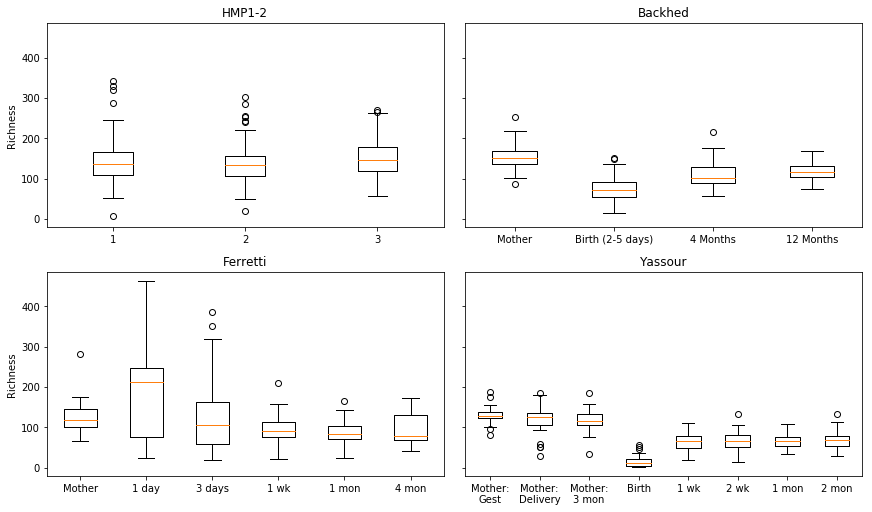

In [35]:
# Plot richness over time for each cohort

fig, ax = plt.subplots(2,2, figsize=(12,7), sharey=True, constrained_layout=True)

# HMP1-2
hmp_samples = su.get_sample_names('HMP')
order_richness_dict = defaultdict(list)
for sample in hmp_samples:
    subject, order = sample_order_map[sample]
    richness = richness_dict[sample]
    order_richness_dict[order].append(richness)

order_list = [1, 2, 3]
order_labels = ['1', '2', '3']
plot_data = [order_richness_dict[o] for o in order_list]

ax[0][0].boxplot(plot_data)
ax[0][0].set_xticklabels(order_labels)
ax[0][0].set_ylabel("Richness")
ax[0][0].set_title("HMP1-2")

# Backhed
backhed_samples = su.get_sample_names('Backhed')
order_richness_dict = defaultdict(list)
for sample in backhed_samples:
    tp = su.sample_to_tp(sample, sample_order_map, hmp_samples, mother_samples)
    richness = richness_dict[sample]
    order_richness_dict[tp].append(richness)

order_list = ['M1', 'I1', 'I2', 'I3']
order_labels = ['Mother', 'Birth (2-5 days)', '4 Months', '12 Months']
plot_data = [order_richness_dict[o] for o in order_list]

ax[0][1].boxplot(plot_data)
ax[0][1].set_xticklabels(order_labels)
ax[0][1].set_title("Backhed")

# Ferretti
ferretti_samples = su.get_sample_names('Ferretti')
order_richness_dict = defaultdict(list)
for sample in ferretti_samples:
    tp = su.sample_to_tp(sample, sample_order_map, hmp_samples, mother_samples)
    richness = richness_dict[sample]
    order_richness_dict[tp].append(richness)

order_list = ['M1', 'I1', 'I2', 'I3', 'I4', 'I5']
order_labels = ['Mother', '1 day', '3 days', '1 wk', '1 mon', '4 mon']
plot_data = [order_richness_dict[o] for o in order_list]

ax[1][0].boxplot(plot_data)
ax[1][0].set_xticklabels(order_labels)
ax[1][0].set_ylabel("Richness")
ax[1][0].set_title("Ferretti")

# Yassour
yassour_samples = su.get_sample_names('Yassour')
order_richness_dict = defaultdict(list)
for sample in yassour_samples:
    tp = su.sample_to_tp(sample, sample_order_map, hmp_samples, mother_samples)
    richness = richness_dict[sample]
    order_richness_dict[tp].append(richness)

order_list = ['M1', 'M2', 'M3', 'I1', 'I2', 'I3', 'I4', 'I5']
order_labels = ['Mother:\nGest', 'Mother:\nDelivery','Mother:\n3 mon', 'Birth', '1 wk', '2 wk', '1 mon', '2 mon', '3 mon']
plot_data = [order_richness_dict[o] for o in order_list]

ax[1][1].boxplot(plot_data)
ax[1][1].set_xticklabels(order_labels)
ax[1][1].set_title("Yassour")

plt.show()

Text(0.5, 1.0, 'Shao')

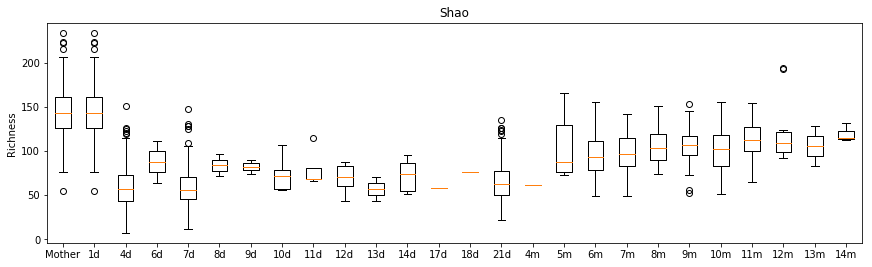

In [36]:
fig, ax = plt.subplots(figsize=(12, 3.6), sharey=True, constrained_layout=True)

# Shao
month_bins = np.arange(4, 15) * 30.5
order_bins = [0, 1, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 21] + list(month_bins)

shao_samples = su.get_sample_names('Shao')
order_richness_dict = defaultdict(list)
for sample in shao_samples:
    subject, order = sample_order_map[sample]
    richness = richness_dict[sample]
    if subject[-1] == 'M': # Mother
        order_richness_dict[0].append(richness)
    if order > 21: # Convert to month bins
        month_bin = round_down(order, 30.5)
        order_richness_dict[month_bin].append(richness)
    else:
        order_richness_dict[order].append(richness)

plot_data = [order_richness_dict[o] for o in order_bins]
order_labels = ['Mother', '1d', '4d', '6d', '7d', '8d', '9d', '10d', '11d', '12d', '13d', '14d', '17d', '18d', '21d', '4m', '5m', '6m', '7m', '8m', '9m', '10m', '11m', '12m', '13m', '14m']

ax.boxplot(plot_data)
ax.set_xticklabels(order_labels)
ax.set_ylabel("Richness")
ax.set_title("Shao")